# <span style="color:green">Libraries</span>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
from scipy.stats import randint, uniform
from collections import Counter
from itertools import product
import json
import onnx
import onnxruntime as ort
import yaml

from IPython.display import Image
from core.mixer import Mixer
from core.cell_types import CellTypes
from core.model import DeconvolutionModel
from core.plotting import print_cell_matras, cells_p, print_all_cells_in_one
from core.utils import *

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import resample


import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
from torch.cuda.amp import autocast, GradScaler 
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torch.nn.functional as F

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# <span style="color:green">Train data</span>

In [4]:
cancer_sample_annot = pd.read_csv('data/cancer_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cancer_expr = pd.read_csv('data/cancer_expr.tsv.tar.gz', sep='\t', index_col=0)
cells_sample_annot = pd.read_csv('data/cells_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cells_expr = pd.read_csv('data/cells_expr.tsv.tar.gz', sep='\t', index_col=0)


filtered_cancer_sample_annot = cancer_sample_annot.drop('SRX2880123')
filtered_cancer_expr = cancer_expr.drop(columns=['SRX2880123'])

stratify_column = 'Tumor_type'  
test_size = 0.5  

train_cancer_sample_annot, test_cancer_sample_annot = train_test_split(
    filtered_cancer_sample_annot,
    test_size=test_size,
    stratify=filtered_cancer_sample_annot[stratify_column],
    random_state=42
)

test_cancer_sample_annot = pd.concat([test_cancer_sample_annot, cancer_sample_annot.loc[['SRX2880123']]], axis=0)
train_samples = train_cancer_sample_annot['Sample'].values
test_samples = test_cancer_sample_annot['Sample'].values

train_cancer_expr = cancer_expr.loc[:, list(train_samples)]
test_cancer_expr = cancer_expr.loc[:, list(test_samples)]

stratify_column = 'Cell_type'
test_size = 0.5  

train_cells_sample_annot, test_cells_sample_annot = train_test_split(
    cells_sample_annot,
    test_size=test_size,
    stratify=cells_sample_annot[stratify_column],
    random_state=42
)

train_cells_samples = train_cells_sample_annot['Sample'].values
test_cells_samples = test_cells_sample_annot['Sample'].values

train_cells_expr = cells_expr.loc[:, list(train_cells_samples)]
test_cells_expr = cells_expr.loc[:, list(test_cells_samples)]

cell_types = CellTypes.load('configs/cell_types.yaml')

In [5]:
mixer_train = Mixer(cell_types=cell_types,
              cells_expr=train_cells_expr, cells_annot=train_cells_sample_annot,
              tumor_expr=train_cancer_expr, tumor_annot=train_cancer_sample_annot,
              num_points=100000, num_av=3)
mixer_test = Mixer(cell_types=cell_types,
              cells_expr=test_cells_expr, cells_annot=test_cells_sample_annot,
              tumor_expr=test_cancer_expr, tumor_annot=test_cancer_sample_annot,
              num_points=100, num_av=3)

def renorm_expressions(expr, genes_in_expressions_file):
    genes_in_expressions = []
    with open(genes_in_expressions_file, 'r') as file:
        for line in file:
            gene = line[:-1]
            genes_in_expressions.append(gene)
    genes = list(set(expr.index) & set(genes_in_expressions))
    renormed_expr = expr.loc[genes].div(expr.loc[genes].sum(axis=0), axis='columns') * 1e6
    return renormed_expr


genes_in_expression_file = './data/genes_in_expression.txt'

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK
Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK


# <span style="color:green">Models</span>

## ConvNeXt model

In [6]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output


class ConvNeXt1DBlock(nn.Module):
    def __init__(self, dim, drop_path=0.1, layer_scale_init_value=1e-6, dropout_rate=0.1):
        super().__init__()


        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate) 
        self.pwconv2 = nn.Linear(4 * dim, dim) 

        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim)) if layer_scale_init_value > 0 else None

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)  
        x = x.permute(0, 2, 1) 
        x = self.norm(x) 
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.dropout(x)  
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 2, 1)  
        x = input + self.drop_path(x)
        return x


class ConvNeXt1DForProportions(nn.Module):
    def __init__(self, in_channels=1, num_cells=4, depths=[3, 3, 6], dims=[128, 256, 512]):
        super().__init__()

 
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, dims[0], kernel_size=4, stride=4),  
            nn.BatchNorm1d(dims[0])  
        )

        self.stages = nn.ModuleList()
        for i in range(len(depths)):
            stage = nn.Sequential(
                *[ConvNeXt1DBlock(dim=dims[i], dropout_rate=0.1) for _ in range(depths[i])]
            )
            self.stages.append(stage)

        self.downsamples = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(dims[i], dims[i+1], kernel_size=2, stride=2), 
                nn.BatchNorm1d(dims[i+1])
            ) for i in range(len(dims)-1)
        ])


        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1), 
            nn.Flatten(),
            nn.LayerNorm(dims[-1], eps=1e-6),
            nn.Linear(dims[-1], num_cells),
            nn.Softmax(dim=-1) 
        )

    def forward(self, x):
        x = self.stem(x)

        for i in range(len(self.stages)):
            x = self.stages[i](x)
            if i < len(self.downsamples):
                x = self.downsamples[i](x)

        x = self.head(x)
        return x

def init_weights(m):
    """
    Custom weight initialization function.
    - Kaiming Normal initialization for Conv1d layers.
    - Xavier Normal initialization for Linear layers.
    """
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## Transformer model

In [7]:
class TransDeconv(nn.Module):
    def __init__(self, input_dim, hidden_dim, nhead, num_layers, latent_dim, output_dim):
        super(TransDeconv, self).__init__()
        
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.embedding_dropout = nn.Dropout(p=0.1)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        self.transformer_dropout = nn.Dropout(p=0.1)
        
        

        self.fc_latent = nn.Linear(hidden_dim, latent_dim)
        self.latent_norm = nn.LayerNorm(latent_dim)
        self.latent_dropout = nn.Dropout(p=0.2)
        self.fc_output = nn.Linear(latent_dim, output_dim)

        self._initialize_weights()
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = self.layer_norm(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = self.transformer_dropout(x)
        x = x.squeeze(1)
        x = self.fc_latent(x)
        x = self.latent_norm(x)
        x = self.latent_dropout(x)
        x = self.fc_output(x)  
        x = F.log_softmax(x, dim=1)  
        return x
    
    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        if self.embedding.bias is not None:
            nn.init.constant_(self.embedding.bias, 0)
        
        nn.init.xavier_uniform_(self.fc_latent.weight)
        if self.fc_latent.bias is not None:
            nn.init.constant_(self.fc_latent.bias, 0)
        
        nn.init.xavier_uniform_(self.fc_output.weight)
        if self.fc_output.bias is not None:
            nn.init.constant_(self.fc_output.bias, 0)

# Training

## ConvNeXt

In [38]:
cells = cell_types.names[:6].copy() + cell_types.names[7:].copy()

In [39]:
cells

['B_cells',
 'CD4_T_cells',
 'CD8_T_cells',
 'Dendritic_cells',
 'Endothelium',
 'Fibroblasts',
 'Granulocytes',
 'Immune_general',
 'Macrophages',
 'Monocytes',
 'Monocytic_cells',
 'NK_cells',
 'Non_plasma_B_cells',
 'Plasma_B_cells',
 'T_cells']

In [21]:
#cells_for_convnext = [cells[7], cells[0], cells[12]]
#ниже надо сделать цикл для обучения трех моделей, for cell in cells_for_convnext
# selected_cell = cell
# Тут этого не сделано, потому что займет очень много времени, надо запускать на отдельном сервере, даже с батчем 1024
# идет долго

In [40]:
selected_cell = 'B_cells'
selected_genes = cell_types[selected_cell].genes.copy()
if selected_cell != 'Immune_general':
    selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])
expr_train, values_train = mixer_train.generate(selected_cell, genes=selected_genes, random_seed=17)


data = expr_train
targets = values_train 
input_size=data.shape[1]

data = renorm_expressions(data, genes_in_expression_file)


X = torch.tensor(data.T.values, dtype=torch.float32)
y = torch.tensor(targets.T.values, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TensorDataset(X, y)

criterion = nn.KLDivLoss(reduction='batchmean', log_target=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def init_weights(m):
    """
    Custom weight initialization function.
    - Kaiming Normal initialization for Conv1d layers.
    - Xavier Normal initialization for Linear layers.
    """
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def train_ConvNeXt(dataset, num_epochs=100, n_splits=5, batch_size=32):
    
    X, y = zip(*[(x, y) for x, y in dataset])  
    X = torch.stack(X)  
    y = torch.stack(y)  


    dominant_classes = y.argmax(dim=1).numpy()  


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    best_val_loss_across_folds = float('inf')
    best_model_path = 'best_ConvNeXt.pth'


    all_train_losses = []
    all_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, dominant_classes)):
        print(f"\nFold {fold + 1}/{n_splits}")
        

        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ConvNeXt1DForProportions(num_cells=values_train.shape[0]).to(device)
        model.apply(init_weights)  
        
        optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        best_val_loss = float('inf')
        patience = 5
        trigger_times = 0
        

        train_losses = []
        val_losses = []


        for epoch in range(num_epochs):
            start_time = time.time()
            model.train()


            train_loss = 0
            for batch in train_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                
                inputs = inputs.unsqueeze(1)  # (batch_size, 1, num_features)

                # Forward pass
                outputs = model(inputs)
                outputs = torch.log(outputs + 1e-9)  # Log-probabilities for KLDivLoss
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            val_loss = validate_model(model, val_loader)
            val_losses.append(val_loss)

            end_time = time.time()
            epoch_time = end_time - start_time

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f} s")

            # Step the LR scheduler based on validation loss
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print("Early stopping!")
                    break

        # Store losses for this fold
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Check if this fold's best validation loss is the best across all folds
        if best_val_loss < best_val_loss_across_folds:
            best_val_loss_across_folds = best_val_loss
            torch.save(model.state_dict(), best_model_path)  # Save the best model across all folds
            print(f"New best model saved with Val Loss: {best_val_loss_across_folds:.4f}")

        # Plot results for this fold
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Fold {fold + 1} - Training and Validation Loss")
        plt.legend()
        plt.show()

    # Aggregate results across folds
    max_epochs = max(len(fold_losses) for fold_losses in all_train_losses)
    avg_train_losses = [sum([fold_losses[epoch] for fold_losses in all_train_losses if epoch < len(fold_losses)]) / n_splits for epoch in range(max_epochs)]
    avg_val_losses = [sum([fold_losses[epoch] for fold_losses in all_val_losses if epoch < len(fold_losses)]) / n_splits for epoch in range(max_epochs)]

    # Plot aggregated results
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_losses, label="Average Train Loss")
    plt.plot(avg_val_losses, label="Average Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Aggregated Training and Validation Loss Across Folds")
    plt.legend()
    plt.show()

    print(f"\nBest model across all folds saved at '{best_model_path}' with Val Loss: {best_val_loss_across_folds:.4f}")


def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Add channel dimension for Conv1d
            inputs = inputs.unsqueeze(1)

            # Forward pass
            outputs = model(inputs)
            outputs = torch.log(outputs + 1e-9)  # Log-probabilities for KLDivLoss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss


Fold 1/5
Epoch [1/100], Train Loss: 1.6581, Val Loss: 1.2330, Time: 13.99 s
Epoch [2/100], Train Loss: 1.0184, Val Loss: 0.8958, Time: 13.62 s
Epoch [3/100], Train Loss: 0.7302, Val Loss: 0.6073, Time: 13.66 s
Epoch [4/100], Train Loss: 0.5237, Val Loss: 0.4680, Time: 13.70 s
Epoch [5/100], Train Loss: 0.4537, Val Loss: 0.4293, Time: 13.85 s
Epoch [6/100], Train Loss: 0.4267, Val Loss: 0.4062, Time: 13.74 s
Epoch [7/100], Train Loss: 0.4076, Val Loss: 0.3904, Time: 13.76 s
Epoch [8/100], Train Loss: 0.3950, Val Loss: 0.3774, Time: 13.75 s
Epoch [9/100], Train Loss: 0.3807, Val Loss: 0.3639, Time: 13.78 s
Epoch [10/100], Train Loss: 0.3709, Val Loss: 0.3527, Time: 13.89 s
Epoch [11/100], Train Loss: 0.3597, Val Loss: 0.3409, Time: 13.78 s
Epoch [12/100], Train Loss: 0.3502, Val Loss: 0.3307, Time: 13.80 s
Epoch [13/100], Train Loss: 0.3419, Val Loss: 0.3215, Time: 13.79 s
Epoch [14/100], Train Loss: 0.3335, Val Loss: 0.3148, Time: 13.91 s
Epoch [15/100], Train Loss: 0.3271, Val Loss: 0

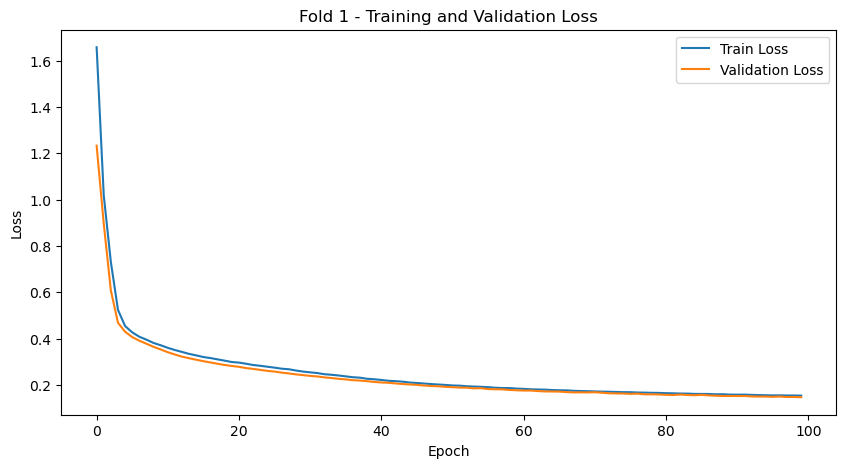


Fold 2/5
Epoch [1/100], Train Loss: 1.4441, Val Loss: 1.1737, Time: 14.25 s
Epoch [2/100], Train Loss: 0.9928, Val Loss: 0.8551, Time: 14.03 s
Epoch [3/100], Train Loss: 0.7216, Val Loss: 0.5813, Time: 14.14 s
Epoch [4/100], Train Loss: 0.5175, Val Loss: 0.4573, Time: 13.93 s
Epoch [5/100], Train Loss: 0.4462, Val Loss: 0.4204, Time: 14.11 s
Epoch [6/100], Train Loss: 0.4219, Val Loss: 0.4022, Time: 14.01 s
Epoch [7/100], Train Loss: 0.4061, Val Loss: 0.3872, Time: 14.10 s
Epoch [8/100], Train Loss: 0.3917, Val Loss: 0.3721, Time: 13.95 s
Epoch [9/100], Train Loss: 0.3788, Val Loss: 0.3607, Time: 14.18 s
Epoch [10/100], Train Loss: 0.3674, Val Loss: 0.3489, Time: 14.01 s
Epoch [11/100], Train Loss: 0.3576, Val Loss: 0.3380, Time: 13.98 s
Epoch [12/100], Train Loss: 0.3480, Val Loss: 0.3287, Time: 14.04 s
Epoch [13/100], Train Loss: 0.3393, Val Loss: 0.3207, Time: 14.14 s
Epoch [14/100], Train Loss: 0.3341, Val Loss: 0.3133, Time: 14.22 s
Epoch [15/100], Train Loss: 0.3268, Val Loss: 0

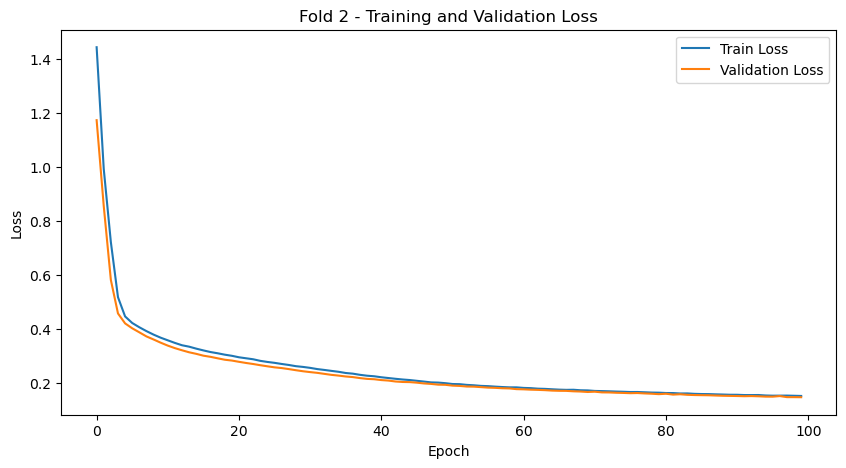


Fold 3/5
Epoch [1/100], Train Loss: 1.3761, Val Loss: 1.1503, Time: 18.51 s
Epoch [2/100], Train Loss: 0.9560, Val Loss: 0.8257, Time: 18.59 s
Epoch [3/100], Train Loss: 0.7097, Val Loss: 0.5736, Time: 17.44 s
Epoch [4/100], Train Loss: 0.5167, Val Loss: 0.4612, Time: 18.12 s
Epoch [5/100], Train Loss: 0.4470, Val Loss: 0.4253, Time: 18.44 s
Epoch [6/100], Train Loss: 0.4217, Val Loss: 0.4051, Time: 18.45 s
Epoch [7/100], Train Loss: 0.4052, Val Loss: 0.3919, Time: 19.14 s
Epoch [8/100], Train Loss: 0.3931, Val Loss: 0.3779, Time: 18.09 s
Epoch [9/100], Train Loss: 0.3809, Val Loss: 0.3667, Time: 17.24 s
Epoch [10/100], Train Loss: 0.3713, Val Loss: 0.3549, Time: 17.19 s
Epoch [11/100], Train Loss: 0.3602, Val Loss: 0.3435, Time: 17.34 s
Epoch [12/100], Train Loss: 0.3505, Val Loss: 0.3344, Time: 17.55 s
Epoch [13/100], Train Loss: 0.3424, Val Loss: 0.3264, Time: 17.31 s
Epoch [14/100], Train Loss: 0.3355, Val Loss: 0.3189, Time: 17.75 s
Epoch [15/100], Train Loss: 0.3296, Val Loss: 0

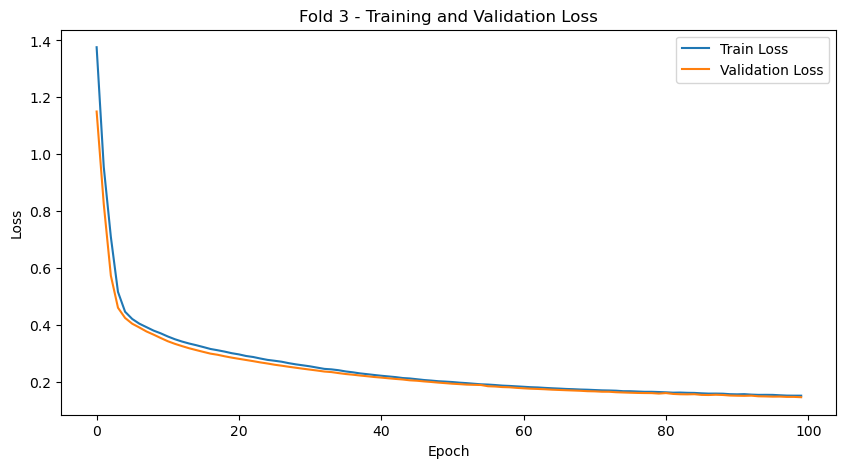


Fold 4/5
Epoch [1/100], Train Loss: 1.3015, Val Loss: 1.0766, Time: 17.23 s
Epoch [2/100], Train Loss: 0.9422, Val Loss: 0.8163, Time: 17.34 s
Epoch [3/100], Train Loss: 0.6781, Val Loss: 0.5509, Time: 16.51 s
Epoch [4/100], Train Loss: 0.4945, Val Loss: 0.4487, Time: 16.95 s
Epoch [5/100], Train Loss: 0.4380, Val Loss: 0.4184, Time: 17.11 s
Epoch [6/100], Train Loss: 0.4166, Val Loss: 0.3987, Time: 17.12 s
Epoch [7/100], Train Loss: 0.4003, Val Loss: 0.3844, Time: 17.25 s
Epoch [8/100], Train Loss: 0.3886, Val Loss: 0.3712, Time: 17.11 s
Epoch [9/100], Train Loss: 0.3747, Val Loss: 0.3587, Time: 17.29 s
Epoch [10/100], Train Loss: 0.3632, Val Loss: 0.3447, Time: 17.41 s
Epoch [11/100], Train Loss: 0.3518, Val Loss: 0.3333, Time: 17.41 s
Epoch [12/100], Train Loss: 0.3435, Val Loss: 0.3241, Time: 17.12 s
Epoch [13/100], Train Loss: 0.3338, Val Loss: 0.3173, Time: 17.13 s
Epoch [14/100], Train Loss: 0.3279, Val Loss: 0.3104, Time: 17.12 s
Epoch [15/100], Train Loss: 0.3216, Val Loss: 0

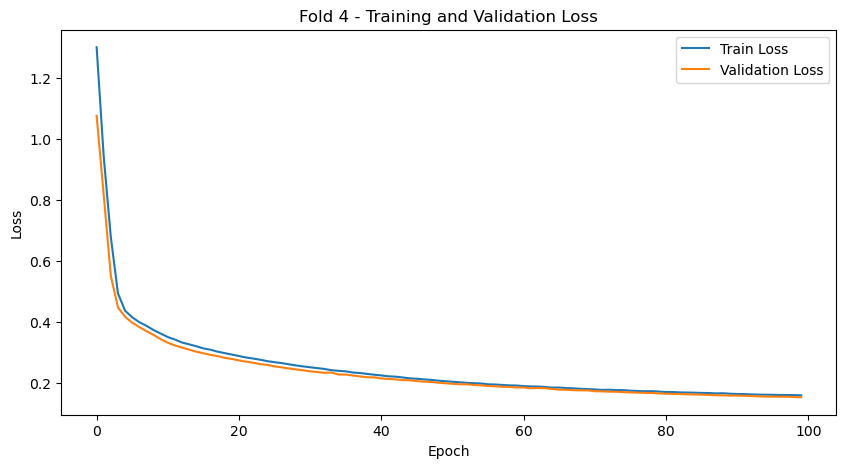


Fold 5/5
Epoch [1/100], Train Loss: 1.3856, Val Loss: 1.0811, Time: 19.74 s
Epoch [2/100], Train Loss: 0.9536, Val Loss: 0.8363, Time: 19.72 s
Epoch [3/100], Train Loss: 0.6950, Val Loss: 0.5697, Time: 19.81 s
Epoch [4/100], Train Loss: 0.5016, Val Loss: 0.4533, Time: 19.85 s
Epoch [5/100], Train Loss: 0.4420, Val Loss: 0.4215, Time: 17.88 s
Epoch [6/100], Train Loss: 0.4180, Val Loss: 0.4023, Time: 19.50 s
Epoch [7/100], Train Loss: 0.4043, Val Loss: 0.3879, Time: 19.46 s
Epoch [8/100], Train Loss: 0.3890, Val Loss: 0.3746, Time: 19.43 s
Epoch [9/100], Train Loss: 0.3781, Val Loss: 0.3621, Time: 19.59 s
Epoch [10/100], Train Loss: 0.3662, Val Loss: 0.3498, Time: 19.59 s
Epoch [11/100], Train Loss: 0.3557, Val Loss: 0.3395, Time: 19.62 s
Epoch [12/100], Train Loss: 0.3472, Val Loss: 0.3308, Time: 19.64 s
Epoch [13/100], Train Loss: 0.3380, Val Loss: 0.3223, Time: 19.72 s
Epoch [14/100], Train Loss: 0.3310, Val Loss: 0.3147, Time: 19.50 s
Epoch [15/100], Train Loss: 0.3239, Val Loss: 0

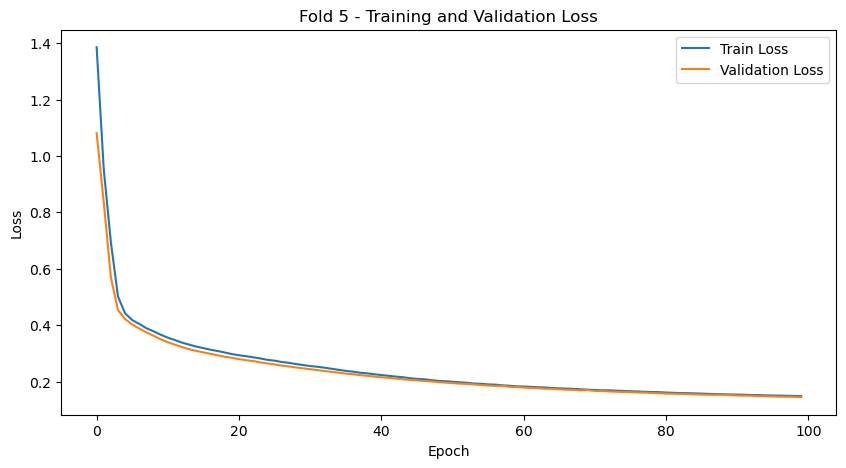

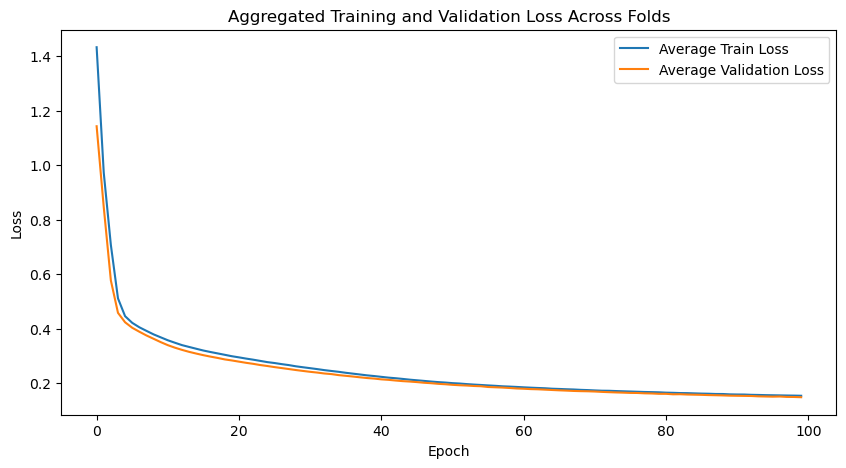


Best model across all folds saved at 'best_ConvNeXt.pth' with Val Loss: 0.1445


In [41]:
train_ConvNeXt(dataset, batch_size=2048)

## Transformers

In [83]:
def load_json_data(selected_cell):
    file_name = f"./transformers/grid_search_results_{selected_cell}.json"
    
    try:
        with open(file_name, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Файл {file_name} не найден.")
        return None
    except json.JSONDecodeError:
        print(f"Ошибка при декодировании JSON в файле {file_name}.")
        return None

def load_model_params(selected_cell, default_params=None):
    if default_params is None:
        default_params = {
            "hidden_dim": 32,
            "nhead": 1,
            "num_layers": 1,
            "latent_dim": 16,
            "lr": 3e-4,
            "weight_decay": 0.01
        }

    file_name = f"./transformers/grid_search_results_{selected_cell}.json"

    try:
        with open(file_name, 'r') as f:
            data = json.load(f)

       
        if selected_cell in data:
            best_params = data[selected_cell]["best_params"]
            params = {k: best_params.get(k, v) for k, v in default_params.items()}

            print(f"[INFO] Параметры успешно загружены из {file_name}")
            return params
        else:
            print(f"[WARNING] Ячейка '{selected_cell}' не найдена в JSON. Используются значения по умолчанию.")
            return default_params

    except FileNotFoundError:
        print(f"[ERROR] Файл {file_name} не найден. Используются значения по умолчанию.")
        return default_params
    except json.JSONDecodeError:
        print(f"[ERROR] Ошибка чтения JSON в файле {file_name}. Используются значения по умолчанию.")
        return default_params
    except Exception as e:
        print(f"[ERROR] Произошла ошибка: {e}. Используются значения по умолчанию.")
        return default_params

[INFO] Параметры успешно загружены из ./transformers/grid_search_results_B_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.3405
Validation Loss for Epoch 1: 0.1997
Saved best overall model with Validation Loss: 0.1997
Epoch [2/100], Train Loss: 0.1932
Validation Loss for Epoch 2: 0.1506
Saved best overall model with Validation Loss: 0.1506
Epoch [3/100], Train Loss: 0.1613
Validation Loss for Epoch 3: 0.1310
Saved best overall model with Validation Loss: 0.1310
Epoch [4/100], Train Loss: 0.1436
Validation Loss for Epoch 4: 0.1203
Saved best overall model with Validation Loss: 0.1203
Epoch [5/100], Train Loss: 0.1305
Validation Loss for Epoch 5: 0.1097
Saved best overall model with Validation Loss: 0.1097
Epoch [6/100], Train Loss: 0.1213
Validation Loss for Epoch 6: 0.1061
Saved best overall model with Validation Loss: 0.1061
Epoch [7/100], Train Loss: 0.1142
Validation Loss for Epoch 7: 0.1003
Saved best overall model with Validation Loss: 0.1003
Epoch [8/100], Train Loss: 0.1090
Validation Loss for Epoch 8: 0.0951
Saved best overall model with Validation Loss: 0.0951
Epoch [9

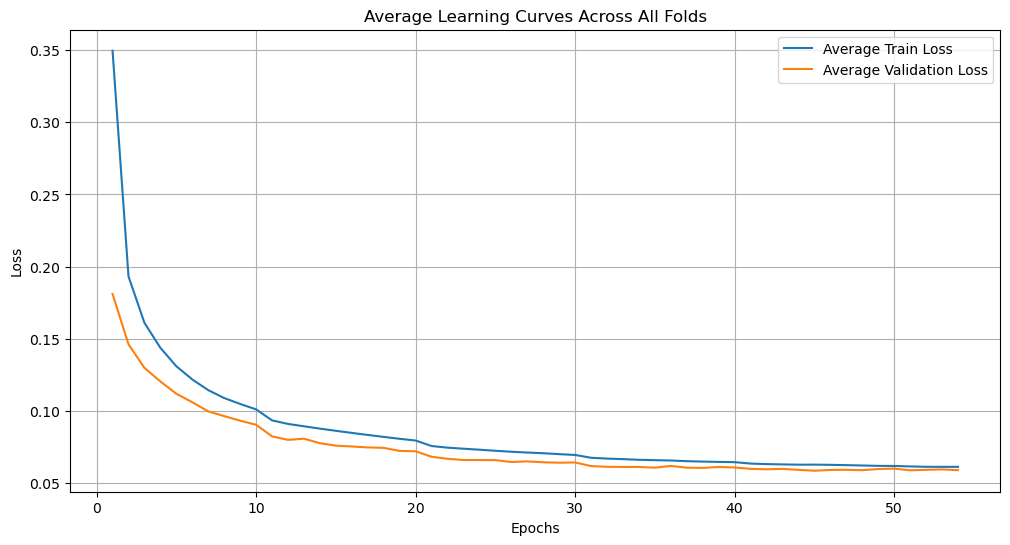

Average Validation Loss across all folds: 0.0597
время на один тип клеток: 256.9053535461426
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_CD4_T_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2667
Validation Loss for Epoch 1: 0.1352
Saved best overall model with Validation Loss: 0.1352
Epoch [2/100], Train Loss: 0.1551
Validation Loss for Epoch 2: 0.1169
Saved best overall model with Validation Loss: 0.1169
Epoch [3/100], Train Loss: 0.1352
Validation Loss for Epoch 3: 0.1095
Saved best overall model with Validation Loss: 0.1095
Epoch [4/100], Train Loss: 0.1241
Validation Loss for Epoch 4: 0.0978
Saved best overall model with Validation Loss: 0.0978
Epoch [5/100], Train Loss: 0.1158
Validation Loss for Epoch 5: 0.0929
Saved best overall model with Validation Loss: 0.0929
Epoch [6/100], Train Loss: 0.1094
Validation Loss for Epoch 6: 0.0882
Saved best overall model with Validation Loss: 0.0882
Epoch [7/100], Train Loss: 0.1045
Validation Loss for Epoch 7: 0

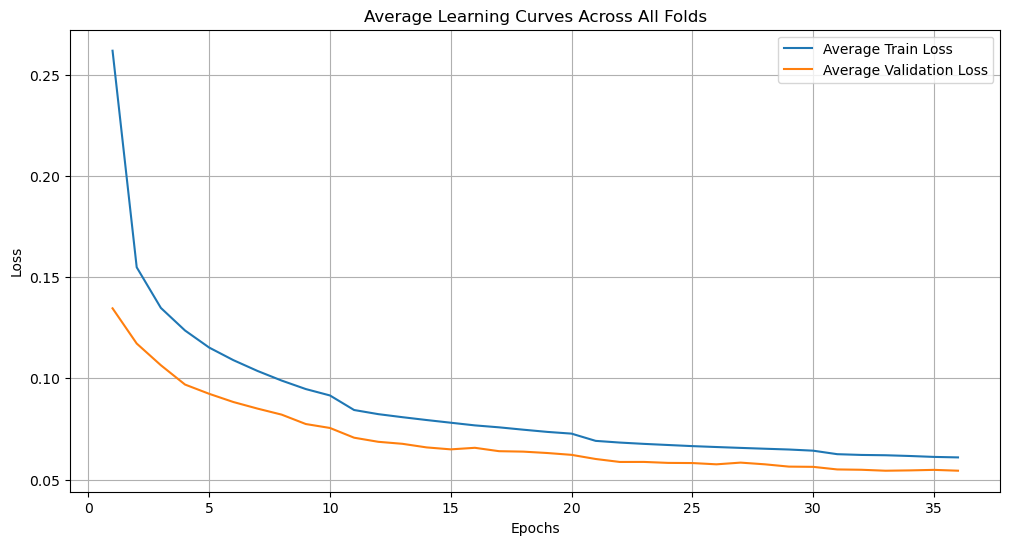

Average Validation Loss across all folds: 0.0569
время на один тип клеток: 172.67914962768555
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_CD8_T_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.3251
Validation Loss for Epoch 1: 0.1722
Saved best overall model with Validation Loss: 0.1722
Epoch [2/100], Train Loss: 0.1955
Validation Loss for Epoch 2: 0.1412
Saved best overall model with Validation Loss: 0.1412
Epoch [3/100], Train Loss: 0.1667
Validation Loss for Epoch 3: 0.1199
Saved best overall model with Validation Loss: 0.1199
Epoch [4/100], Train Loss: 0.1510
Validation Loss for Epoch 4: 0.1112
Saved best overall model with Validation Loss: 0.1112
Epoch [5/100], Train Loss: 0.1404
Validation Loss for Epoch 5: 0.1025
Saved best overall model with Validation Loss: 0.1025
Epoch [6/100], Train Loss: 0.1331
Validation Loss for Epoch 6: 0.1028
Epoch [7/100], Train Loss: 0.1264
Validation Loss for Epoch 7: 0.0940
Saved best overall model with Validation Loss: 

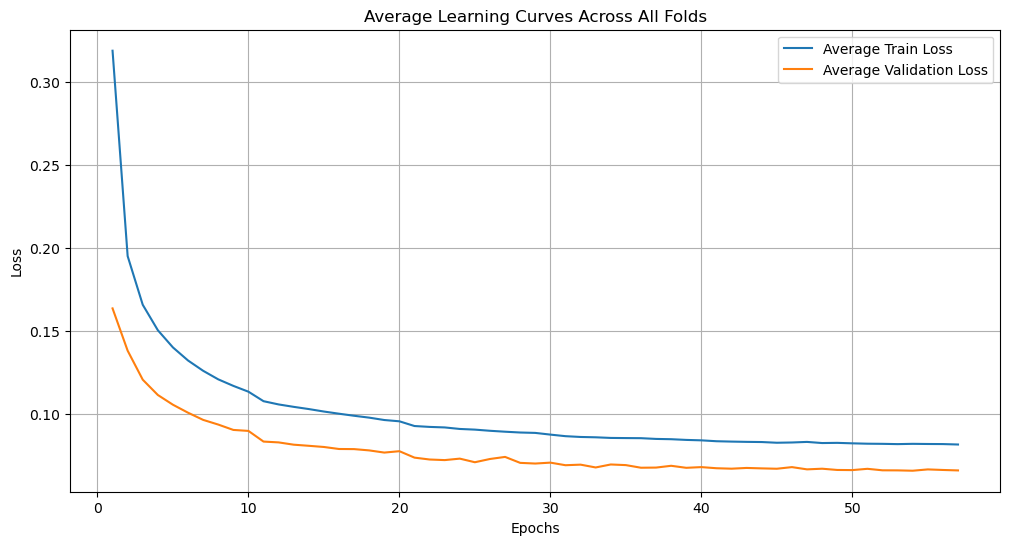

Average Validation Loss across all folds: 0.0733
время на один тип клеток: 216.00933361053467
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Dendritic_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2639
Validation Loss for Epoch 1: 0.1401
Saved best overall model with Validation Loss: 0.1401
Epoch [2/100], Train Loss: 0.1521
Validation Loss for Epoch 2: 0.1160
Saved best overall model with Validation Loss: 0.1160
Epoch [3/100], Train Loss: 0.1328
Validation Loss for Epoch 3: 0.1035
Saved best overall model with Validation Loss: 0.1035
Epoch [4/100], Train Loss: 0.1215
Validation Loss for Epoch 4: 0.1067
Epoch [5/100], Train Loss: 0.1146
Validation Loss for Epoch 5: 0.0950
Saved best overall model with Validation Loss: 0.0950
Epoch [6/100], Train Loss: 0.1078
Validation Loss for Epoch 6: 0.0906
Saved best overall model with Validation Loss: 0.0906
Epoch [7/100], Train Loss: 0.1034
Validation Loss for Epoch 7: 0.0873
Saved best overall model with Validation Lo

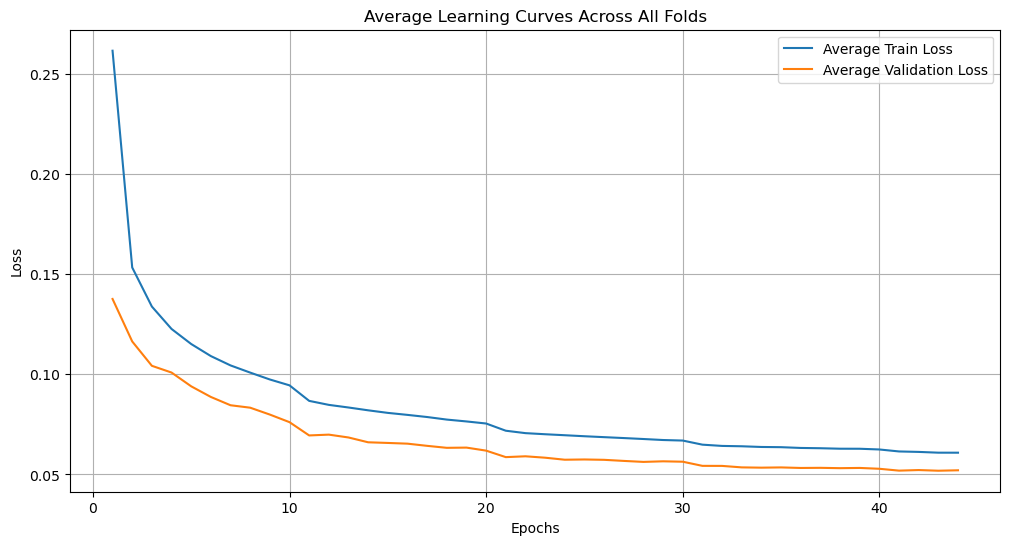

Average Validation Loss across all folds: 0.0544
время на один тип клеток: 203.57067227363586
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Endothelium.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.1626
Validation Loss for Epoch 1: 0.0858
Saved best overall model with Validation Loss: 0.0858
Epoch [2/100], Train Loss: 0.1003
Validation Loss for Epoch 2: 0.0681
Saved best overall model with Validation Loss: 0.0681
Epoch [3/100], Train Loss: 0.0844
Validation Loss for Epoch 3: 0.0610
Saved best overall model with Validation Loss: 0.0610
Epoch [4/100], Train Loss: 0.0764
Validation Loss for Epoch 4: 0.0561
Saved best overall model with Validation Loss: 0.0561
Epoch [5/100], Train Loss: 0.0708
Validation Loss for Epoch 5: 0.0546
Saved best overall model with Validation Loss: 0.0546
Epoch [6/100], Train Loss: 0.0668
Validation Loss for Epoch 6: 0.0533
Saved best overall model with Validation Loss: 0.0533
Epoch [7/100], Train Loss: 0.0638
Validation Loss for Epoch 7: 0.0481
Saved best overall model with Validation Loss: 0.0481
Epoch [8/100], Train Loss: 0.0609
Validation Loss for Epoch 8: 0.0527
Epoch [9/100], Train Loss: 0.0586
Validation Loss for Epoch 9:

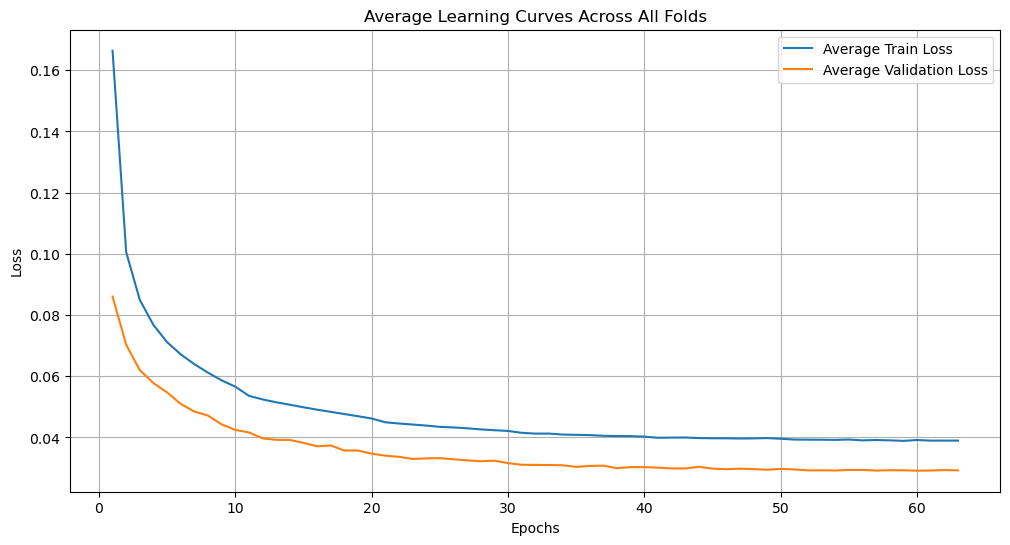

Average Validation Loss across all folds: 0.0309
время на один тип клеток: 217.46717524528503
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Fibroblasts.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.1589
Validation Loss for Epoch 1: 0.0517
Saved best overall model with Validation Loss: 0.0517
Epoch [2/100], Train Loss: 0.0560
Validation Loss for Epoch 2: 0.0389
Saved best overall model with Validation Loss: 0.0389
Epoch [3/100], Train Loss: 0.0457
Validation Loss for Epoch 3: 0.0394
Epoch [4/100], Train Loss: 0.0401
Validation Loss for Epoch 4: 0.0338
Saved best overall model with Validation Loss: 0.0338
Epoch [5/100], Train Loss: 0.0364
Validation Loss for Epoch 5: 0.0278
Saved best overall model with Validation Loss: 0.0278
Epoch [6/100], Train Loss: 0.0341
Validation Loss for Epoch 6: 0.0275
Saved best overall model with Validation Loss: 0.0275
Epoch [7/100], Train Loss: 0.0316
Validation Loss for Epoch 7: 0.0277
Epoch [8/100], Train Loss: 0.0298
Validation Loss for Epoch 8: 0.0253
Saved best overall model with Validation Loss: 0.0253
Epoch [9/100], Train Loss: 0.0283
Validation Loss for Epoch 9: 0.0238
Saved best overall model with Validation Loss:

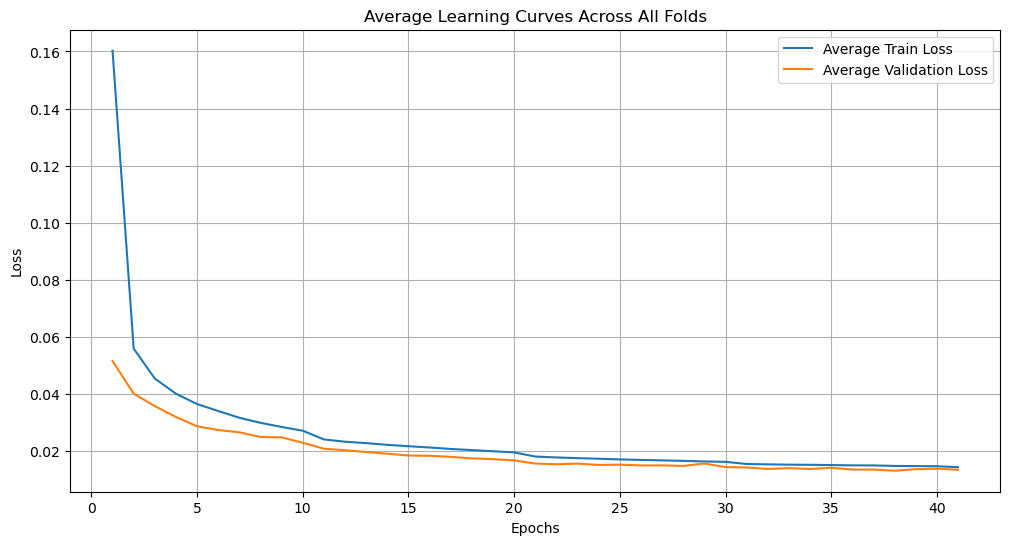

Average Validation Loss across all folds: 0.0143
время на один тип клеток: 182.60262823104858
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Granulocytes.json
Fold 1/5
Epoch [1/100], Train Loss: 0.3226
Validation Loss for Epoch 1: 0.1454
Saved best overall model with Validation Loss: 0.1454
Epoch [2/100], Train Loss: 0.1610
Validation Loss for Epoch 2: 0.1280
Saved best overall model with Validation Loss: 0.1280
Epoch [3/100], Train Loss: 0.1373
Validation Loss for Epoch 3: 0.1139
Saved best overall model with Validation Loss: 0.1139
Epoch [4/100], Train Loss: 0.1258
Validation Loss for Epoch 4: 0.1059
Saved best overall model with Validation Loss: 0.1059
Epoch [5/100], Train Loss: 0.1172
Validation Loss for Epoch 5: 0.1012
Saved best overall model with Validation Loss: 0.1012
Epoch [6/100], Train Loss: 0.1098
Validation Loss for Epoch 6: 0.0971
Saved best overall model with Validation Loss: 0.0971
Epoch [7/100], Train Loss: 0.1038
Validation Loss for Epoch 7:

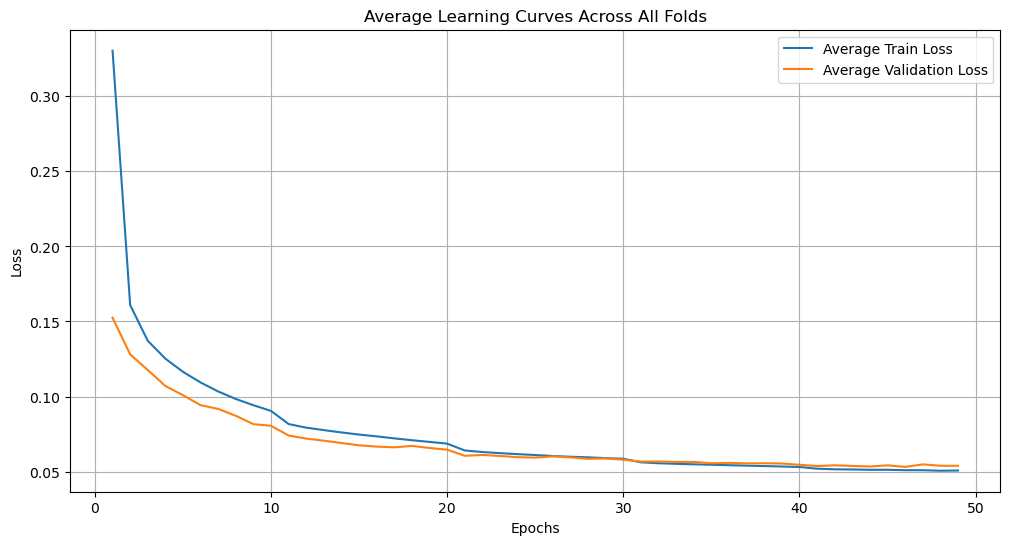

Average Validation Loss across all folds: 0.0561
время на один тип клеток: 303.4308226108551
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Immune_general.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.2067
Validation Loss for Epoch 1: 0.1309
Saved best overall model with Validation Loss: 0.1309
Epoch [2/100], Train Loss: 0.1388
Validation Loss for Epoch 2: 0.1148
Saved best overall model with Validation Loss: 0.1148
Epoch [3/100], Train Loss: 0.1218
Validation Loss for Epoch 3: 0.0978
Saved best overall model with Validation Loss: 0.0978
Epoch [4/100], Train Loss: 0.1110
Validation Loss for Epoch 4: 0.0896
Saved best overall model with Validation Loss: 0.0896
Epoch [5/100], Train Loss: 0.1035
Validation Loss for Epoch 5: 0.0816
Saved best overall model with Validation Loss: 0.0816
Epoch [6/100], Train Loss: 0.0968
Validation Loss for Epoch 6: 0.0768
Saved best overall model with Validation Loss: 0.0768
Epoch [7/100], Train Loss: 0.0920
Validation Loss for Epoch 7: 0.0746
Saved best overall model with Validation Loss: 0.0746
Epoch [8/100], Train Loss: 0.0879
Validation Loss for Epoch 8: 0.0714
Saved best overall model with Validation Loss: 0.0714
Epoch [9

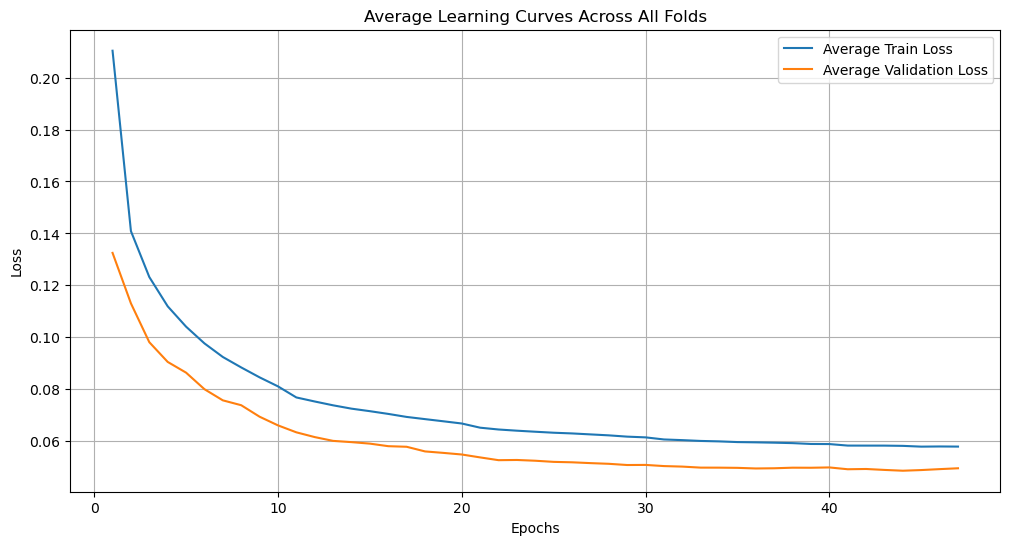

Average Validation Loss across all folds: 0.0487
время на один тип клеток: 225.9109718799591
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Macrophages.json
Fold 1/5
Epoch [1/100], Train Loss: 0.3336
Validation Loss for Epoch 1: 0.1704
Saved best overall model with Validation Loss: 0.1704
Epoch [2/100], Train Loss: 0.1984
Validation Loss for Epoch 2: 0.1349
Saved best overall model with Validation Loss: 0.1349
Epoch [3/100], Train Loss: 0.1658
Validation Loss for Epoch 3: 0.1166
Saved best overall model with Validation Loss: 0.1166
Epoch [4/100], Train Loss: 0.1488
Validation Loss for Epoch 4: 0.1070
Saved best overall model with Validation Loss: 0.1070
Epoch [5/100], Train Loss: 0.1370
Validation Loss for Epoch 5: 0.1002
Saved best overall model with Validation Loss: 0.1002
Epoch [6/100], Train Loss: 0.1277
Validation Loss for Epoch 6: 0.0928
Saved best overall model with Validation Loss: 0.0928
Epoch [7/100], Train Loss: 0.1210
Validation Loss for Epoch 7: 0

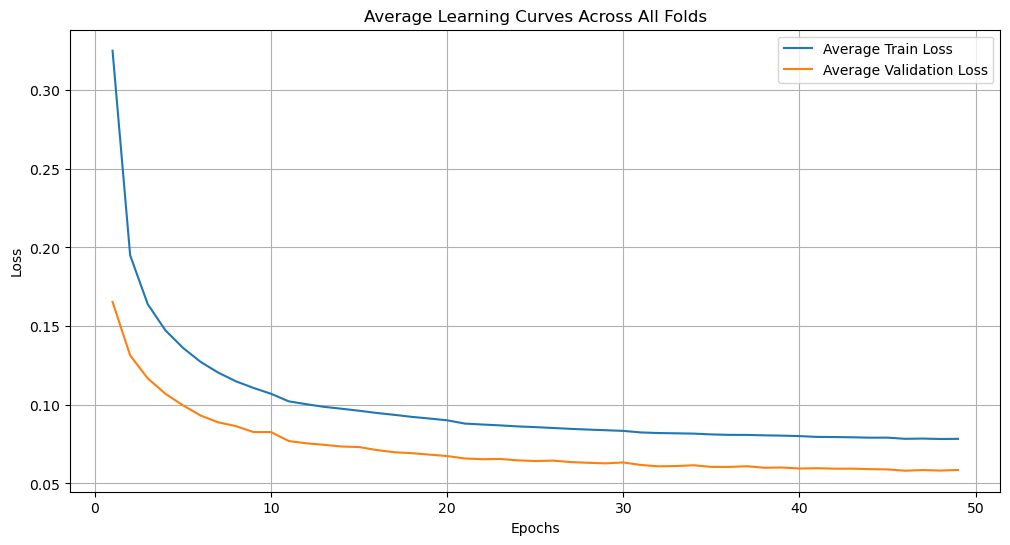

Average Validation Loss across all folds: 0.0607
время на один тип клеток: 214.54717111587524
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Monocytes.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2644
Validation Loss for Epoch 1: 0.1143
Saved best overall model with Validation Loss: 0.1143
Epoch [2/100], Train Loss: 0.1212
Validation Loss for Epoch 2: 0.0828
Saved best overall model with Validation Loss: 0.0828
Epoch [3/100], Train Loss: 0.0967
Validation Loss for Epoch 3: 0.0719
Saved best overall model with Validation Loss: 0.0719
Epoch [4/100], Train Loss: 0.0865
Validation Loss for Epoch 4: 0.0658
Saved best overall model with Validation Loss: 0.0658
Epoch [5/100], Train Loss: 0.0797
Validation Loss for Epoch 5: 0.0594
Saved best overall model with Validation Loss: 0.0594
Epoch [6/100], Train Loss: 0.0743
Validation Loss for Epoch 6: 0.0576
Saved best overall model with Validation Loss: 0.0576
Epoch [7/100], Train Loss: 0.0699
Validation Loss for Epoch 7: 0.

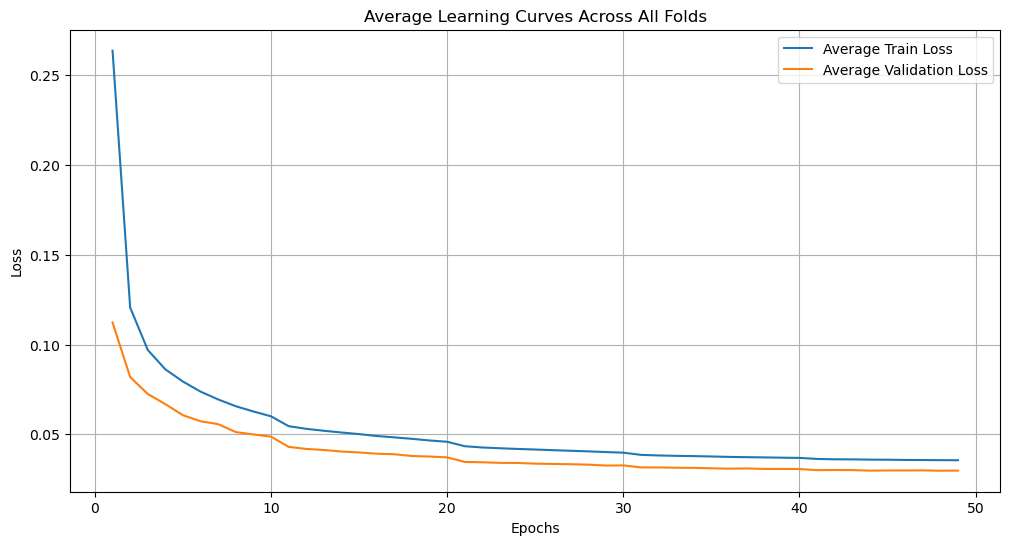

Average Validation Loss across all folds: 0.0300
время на один тип клеток: 271.5583300590515
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Monocytic_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.2782
Validation Loss for Epoch 1: 0.1562
Saved best overall model with Validation Loss: 0.1562
Epoch [2/100], Train Loss: 0.1782
Validation Loss for Epoch 2: 0.1219
Saved best overall model with Validation Loss: 0.1219
Epoch [3/100], Train Loss: 0.1563
Validation Loss for Epoch 3: 0.1126
Saved best overall model with Validation Loss: 0.1126
Epoch [4/100], Train Loss: 0.1437
Validation Loss for Epoch 4: 0.1052
Saved best overall model with Validation Loss: 0.1052
Epoch [5/100], Train Loss: 0.1360
Validation Loss for Epoch 5: 0.1005
Saved best overall model with Validation Loss: 0.1005
Epoch [6/100], Train Loss: 0.1297
Validation Loss for Epoch 6: 0.0943
Saved best overall model with Validation Loss: 0.0943
Epoch [7/100], Train Loss: 0.1243
Validation Loss for Epoch 7: 0.0976
Epoch [8/100], Train Loss: 0.1198
Validation Loss for Epoch 8: 0.0890
Saved best overall model with Validation Loss: 0.0890
Epoch [9/100], Train Loss: 0.1166
Validation Loss for Epoch 9:

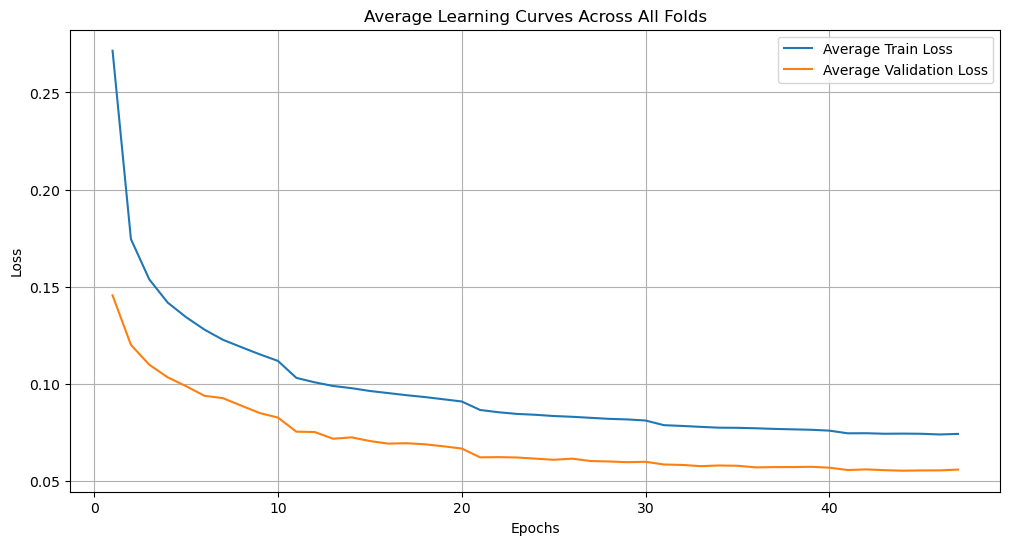

Average Validation Loss across all folds: 0.0573
время на один тип клеток: 293.64210414886475
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_NK_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.2990
Validation Loss for Epoch 1: 0.1580
Saved best overall model with Validation Loss: 0.1580
Epoch [2/100], Train Loss: 0.1601
Validation Loss for Epoch 2: 0.1196
Saved best overall model with Validation Loss: 0.1196
Epoch [3/100], Train Loss: 0.1351
Validation Loss for Epoch 3: 0.1116
Saved best overall model with Validation Loss: 0.1116
Epoch [4/100], Train Loss: 0.1223
Validation Loss for Epoch 4: 0.1060
Saved best overall model with Validation Loss: 0.1060
Epoch [5/100], Train Loss: 0.1145
Validation Loss for Epoch 5: 0.0971
Saved best overall model with Validation Loss: 0.0971
Epoch [6/100], Train Loss: 0.1068
Validation Loss for Epoch 6: 0.0906
Saved best overall model with Validation Loss: 0.0906
Epoch [7/100], Train Loss: 0.1015
Validation Loss for Epoch 7: 0.0916
Epoch [8/100], Train Loss: 0.0965
Validation Loss for Epoch 8: 0.0804
Saved best overall model with Validation Loss: 0.0804
Epoch [9/100], Train Loss: 0.0921
Validation Loss for Epoch 9:

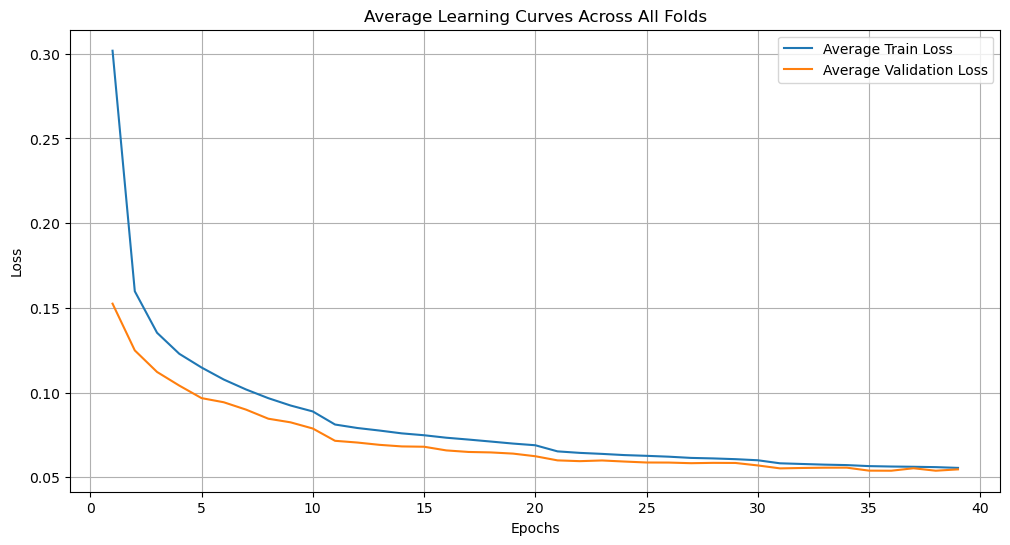

Average Validation Loss across all folds: 0.0572
время на один тип клеток: 184.56565165519714
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Non_plasma_B_cells.json
Fold 1/5


/home/lev/miniforge3/envs/diploma/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/100], Train Loss: 0.3218
Validation Loss for Epoch 1: 0.1886
Saved best overall model with Validation Loss: 0.1886
Epoch [2/100], Train Loss: 0.2036
Validation Loss for Epoch 2: 0.1506
Saved best overall model with Validation Loss: 0.1506
Epoch [3/100], Train Loss: 0.1741
Validation Loss for Epoch 3: 0.1399
Saved best overall model with Validation Loss: 0.1399
Epoch [4/100], Train Loss: 0.1551
Validation Loss for Epoch 4: 0.1289
Saved best overall model with Validation Loss: 0.1289
Epoch [5/100], Train Loss: 0.1431
Validation Loss for Epoch 5: 0.1138
Saved best overall model with Validation Loss: 0.1138
Epoch [6/100], Train Loss: 0.1338
Validation Loss for Epoch 6: 0.1130
Saved best overall model with Validation Loss: 0.1130
Epoch [7/100], Train Loss: 0.1269
Validation Loss for Epoch 7: 0.1028
Saved best overall model with Validation Loss: 0.1028
Epoch [8/100], Train Loss: 0.1221
Validation Loss for Epoch 8: 0.1018
Saved best overall model with Validation Loss: 0.1018
Epoch [9

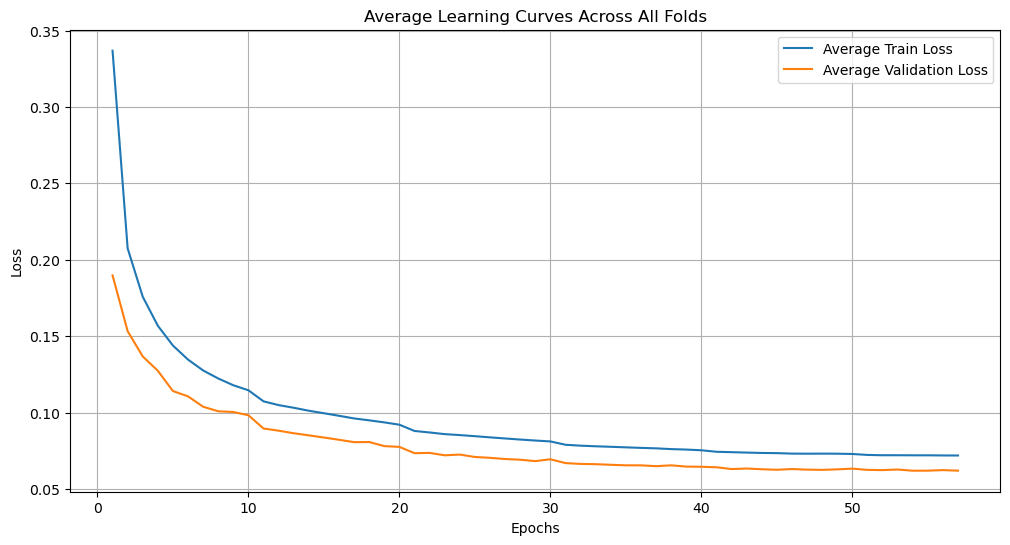

Average Validation Loss across all folds: 0.0639
время на один тип клеток: 264.3242425918579
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_Plasma_B_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.4209
Validation Loss for Epoch 1: 0.2138
Saved best overall model with Validation Loss: 0.2138
Epoch [2/100], Train Loss: 0.2269
Validation Loss for Epoch 2: 0.1761
Saved best overall model with Validation Loss: 0.1761
Epoch [3/100], Train Loss: 0.1936
Validation Loss for Epoch 3: 0.1631
Saved best overall model with Validation Loss: 0.1631
Epoch [4/100], Train Loss: 0.1783
Validation Loss for Epoch 4: 0.1396
Saved best overall model with Validation Loss: 0.1396
Epoch [5/100], Train Loss: 0.1696
Validation Loss for Epoch 5: 0.1366
Saved best overall model with Validation Loss: 0.1366
Epoch [6/100], Train Loss: 0.1636
Validation Loss for Epoch 6: 0.1311
Saved best overall model with Validation Loss: 0.1311
Epoch [7/100], Train Loss: 0.1582
Validation Loss for Epoch 7

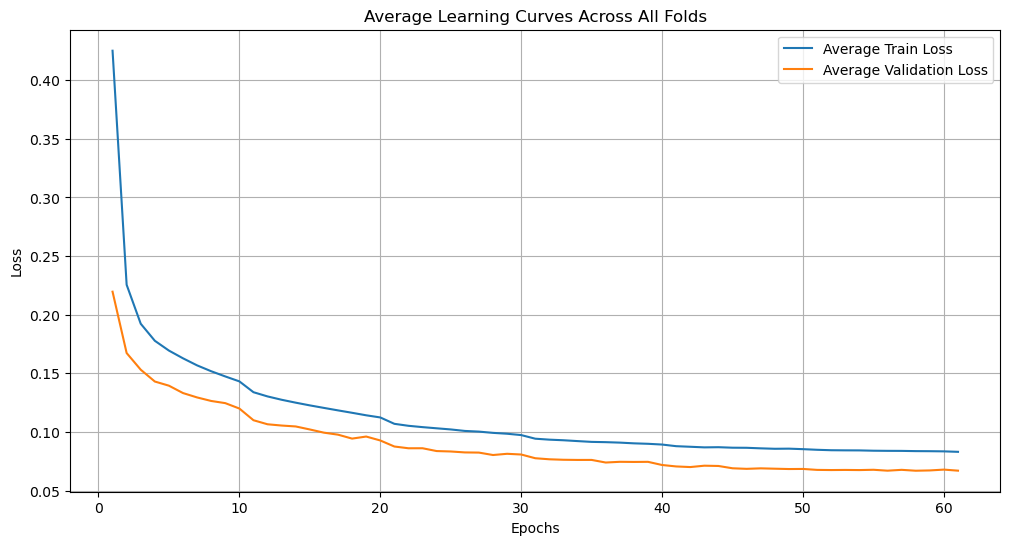

Average Validation Loss across all folds: 0.0760
время на один тип клеток: 218.78227162361145
[INFO] Параметры успешно загружены из ./transformers/grid_search_results_T_cells.json
Fold 1/5
Epoch [1/100], Train Loss: 0.2936
Validation Loss for Epoch 1: 0.1377
Saved best overall model with Validation Loss: 0.1377
Epoch [2/100], Train Loss: 0.1529
Validation Loss for Epoch 2: 0.1148
Saved best overall model with Validation Loss: 0.1148
Epoch [3/100], Train Loss: 0.1300
Validation Loss for Epoch 3: 0.1192
Epoch [4/100], Train Loss: 0.1191
Validation Loss for Epoch 4: 0.1024
Saved best overall model with Validation Loss: 0.1024
Epoch [5/100], Train Loss: 0.1111
Validation Loss for Epoch 5: 0.0940
Saved best overall model with Validation Loss: 0.0940
Epoch [6/100], Train Loss: 0.1045
Validation Loss for Epoch 6: 0.0910
Saved best overall model with Validation Loss: 0.0910
Epoch [7/100], Train Loss: 0.0990
Validation Loss for Epoch 7: 0.0894
Saved best overall model with Validation Loss: 0.08

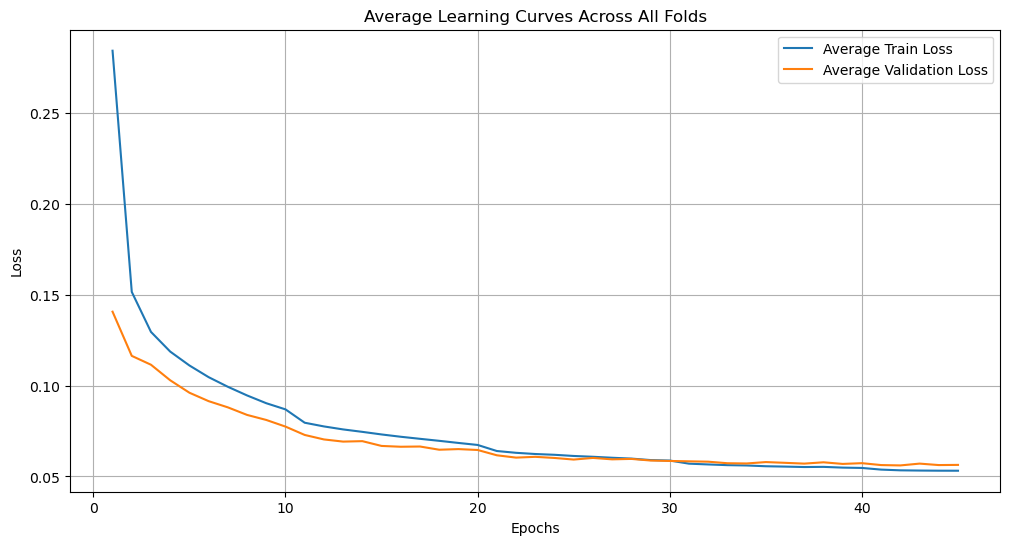

Average Validation Loss across all folds: 0.0593
время на один тип клеток: 181.38082480430603


In [84]:
for selected_cell in cells:
    start = time.time()

    selected_genes = cell_types[selected_cell].genes.copy()
    if selected_cell != 'Immune_general':
        selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])
    
    
    expr_train, values_train = mixer_train.generate(selected_cell, 
                                                genes = selected_genes,
                                                random_seed=17)
    expr_train = renorm_expressions(expr_train, genes_in_expression_file)
    params = load_model_params(selected_cell)
    hidden_dim = params["hidden_dim"]
    nhead = params["nhead"]
    num_layers = params["num_layers"]
    latent_dim = params["latent_dim"]
    lr = params["lr"]
    weight_decay = params["weight_decay"]

    data = expr_train
    targets = values_train
    input_dim = data.shape[0] 
    output_dim = targets.shape[0]  
    
    criterion = nn.KLDivLoss(reduction='batchmean')
    
    batch_size = 256
    num_epochs = 100
    patience = 3
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    X_train_tensor = torch.tensor(data.T.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(targets.T.values, dtype=torch.float32)

    fold_metrics = []

    all_train_losses = []
    all_val_losses = []
    
    best_overall_val_loss = float('inf')
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        X_train_fold = X_train_tensor[train_idx]
        y_train_fold = y_train_tensor[train_idx]
        X_val_fold = X_train_tensor[val_idx]
        y_val_fold = y_train_tensor[val_idx]
    
        train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size, shuffle=False)
        
        model = TransDeconv(input_dim, hidden_dim, nhead, num_layers, latent_dim, output_dim).to(device) 
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        
        train_losses = []
        val_losses = []
        
        best_val_loss = float('inf')
        patience_counter = 0
        
    
        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
    
                outputs = model(batch_X)
                
                loss = criterion(outputs, batch_y)
                
    
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                total_train_loss += loss.item()
            
            scheduler.step() 
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
            
    
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    
                    # Loss
                    loss = criterion(outputs, batch_y)
                    total_val_loss += loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")
            
    
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                
    
                if best_val_loss < best_overall_val_loss:
                    best_overall_val_loss = best_val_loss
                    best_model_path = f"./best_{selected_cell}_trans.pth"
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Saved best overall model with Validation Loss: {best_overall_val_loss:.4f}")
            
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break
        
        fold_metrics.append(best_val_loss)
        print(f"Best Validation Loss for Fold {fold + 1}: {best_val_loss:.4f}\n")
    
        
    
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
    
    
    max_len = max(len(lst) for lst in all_train_losses)
    all_train_losses_padded = [lst + [float('nan')] * (max_len - len(lst)) for lst in all_train_losses]
    all_val_losses_padded = [lst + [float('nan')] * (max_len - len(lst)) for lst in all_val_losses]
    
    avg_train_losses = np.nanmean(all_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(all_val_losses_padded, axis=0)
    
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Average Train Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, label='Average Validation Loss')
    plt.title('Average Learning Curves Across All Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    print(f"Average Validation Loss across all folds: {np.mean(fold_metrics):.4f}")
    model.load_state_dict(torch.load(f"best_{selected_cell}_trans.pth"))   
    model.to("cpu")
    model.eval()

    dummy_expr, dummy_targets = mixer_test.generate(selected_cell,
                                                    selected_genes,
                                                    random_seed=17)
    dummy_input = renorm_expressions(dummy_expr, genes_in_expression_file)
    test_input = torch.tensor(dummy_input.T.values,
                           dtype=torch.float32)
    onnx_model_path = f'./transformers/{selected_cell}_trans.onnx'
    torch.onnx.export(
        model,
        test_input,
        onnx_model_path,
    
        export_params=True,
    
        opset_version=14,
    
        do_constant_folding=False,
        input_names=['bulk_normalized_vector'],
        output_names=['cell_proportions'],
        dynamic_axes={
            'bulk_normalized_vector': {0: 'batch_size'},  
            'cell_proportions': {0: 'batch_size'}
        }
    )
    end = time.time()
    print(f"время на один тип клеток: {end - start}")

# Uploading

## ConvNeXt

In [10]:
model_Immune_general = ConvNeXt1DForProportions()
model_Immune_general.load_state_dict(torch.load(f'Immune_general_best_model_336_power789.pth', weights_only=True))

<All keys matched successfully>

In [26]:
model_Non_Plasma_B_cells = ConvNeXt1DForProportions(num_cells=10)
model_Non_Plasma_B_cells.load_state_dict(torch.load(f'best_Non_plasma_B_cells_ConvNeXt.pth', weights_only=True))

<All keys matched successfully>

In [42]:
model_B_cells = ConvNeXt1DForProportions(num_cells=9)
model_B_cells.load_state_dict(torch.load(f'best_ConvNeXt.pth'))

<All keys matched successfully>

## Transformers

In [125]:
dataset = 'Publication validation set'
cytof = pd.read_csv('data/validation_datasets/cytometry_df.tsv', sep='\t', index_col=0)
expr = pd.read_csv('data/validation_datasets/blood_expr.tsv', sep='\t', index_col=0)
final_predictions = pd.DataFrame()


for selected_cell in cells:
    print(f"Predicting for {selected_cell}...")


    onnx_model_path = f'./transformers/{selected_cell}_trans.onnx'

    selected_genes = cell_types[selected_cell].genes.copy()
    if selected_cell != 'Immune_general':
        selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])    


    val_genes = selected_genes
    val_expr = expr.loc[selected_genes]
    val_expr = renorm_expressions(val_expr, genes_in_expression_file)
    X_test = torch.tensor(val_expr.T.values, dtype=torch.float32)
    dummy_data, dummy_target = mixer_test.generate(selected_cell,
                                       selected_genes,
                                       random_seed=17)
    indeces = dummy_target.index.copy()
    dummy_input = X_test 


    try:
        onnx_model = onnx.load(onnx_model_path)
        onnx.checker.check_model(onnx_model)
        
        ort_session = ort.InferenceSession(onnx_model_path)
    except Exception as e:
        print(f"Ошибка при загрузке модели для {selected_cell}: {e}")
        continue

    all_outputs = []

    for i in range(dummy_input.shape[0]):
        single_sample = dummy_input[i:i+1]  

        outputs = ort_session.run(
            None,
            {'bulk_normalized_vector': single_sample.numpy()}
        )[0]

        all_outputs.append(outputs)

    outputs = np.vstack(all_outputs) 
    predictions = np.exp(outputs.T)*100

    df_pred = pd.DataFrame(predictions, index=indeces, columns=expr.columns)


    df_pred_filtered = df_pred.drop(index=selected_cell, errors='ignore')
    final_predictions = pd.concat([final_predictions, df_pred_filtered], axis=0)
    

predictions = final_predictions.groupby(final_predictions.index, sort=False).mean()

Predicting for B_cells...
Predicting for CD4_T_cells...
Predicting for CD8_T_cells...
Predicting for Dendritic_cells...
Predicting for Endothelium...
Predicting for Fibroblasts...
Predicting for Granulocytes...
Predicting for Immune_general...
Predicting for Macrophages...
Predicting for Monocytes...
Predicting for Monocytic_cells...
Predicting for NK_cells...
Predicting for Non_plasma_B_cells...
Predicting for Plasma_B_cells...
Predicting for T_cells...


# Benchmarking

## Functions to process predictions

In [44]:
def adjust_rna_fractions(preds: pd.DataFrame,
                         cell_config_path: str, add_other: bool = False) -> pd.DataFrame:
    """
    Adjust predictions to respect hierarchy of cell types.
    Each subtype is scaled to sum up to its parent's value.

    :param preds: DataFrame with predictions (samples x cell types)
    :param cell_config_path: Path to cell config YAML
    :param add_other: Whether to add 'Other' class if sum < 1
    :return: Adjusted predictions
    """
    with open(cell_config_path, "r") as f:
        config = yaml.safe_load(f)

    
    root = next(ct for ct in config if config[ct].get("parent_type") is None)

    
    available_types = preds.index.tolist()

    
    general_types = [ct for ct in config[root].get("subtypes", []) if ct in available_types]

    preds = preds.copy()
    preds[preds < 0] = 0

    
    for sample in preds.index:
        total = preds.loc[sample, general_types].sum()
        if total < 1 and add_other:
            preds.loc[sample, "Other"] = 1 - total
        else:
            preds.loc[sample, general_types] /= total
            preds.loc[sample, "Other"] = 0

    
    queue = general_types[:]
    while queue:
        cell = queue.pop()
        subtypes = config[cell].get("subtypes", [])
        subtypes = [ct for ct in subtypes if ct in preds.columns]

        if not subtypes:
            continue

        total = preds[subtypes].sum(axis=1)
        preds[subtypes] = preds[subtypes].divide(total, axis=0).multiply(preds[cell], axis=0)
        queue = subtypes + queue

    return preds


def convert_rna_to_cells_fractions(
    rna_fractions: pd.DataFrame, cell_config_path: str, other_coeff: float = 1.0
) -> pd.DataFrame:
    """
    Converts RNA fractions into real cell fractions using rna_per_cell coefficients.

    :param rna_fractions: RNA-based predicted fractions (cell types x samples)
    :param cell_config_path: Path to cell config YAML
    :param other_coeff: Coefficient for 'Other' class
    :return: Final adjusted cell fractions (cell types x samples)
    """
    with open(cell_config_path, "r") as f:
        config = yaml.safe_load(f)

    # Все типы из preds (в индексе)
    available_types = rna_fractions.index.tolist()

    # Определяем терминальные типы (без подтипов)
    def is_terminal(cell):
        subtypes = config[cell].get("subtypes", [])
        return not any(st in available_types for st in subtypes)

    terminal_models = [ct for ct in available_types if is_terminal(ct)]

    # Коэффициенты
    coefs = {"Other": other_coeff}
    for cell in terminal_models:
        coefs[cell] = config[cell].get("rna_per_cell", 1.0)  # Если NULL → 1.0

    coefs = pd.Series(coefs)

    # Применяем коэффициенты
    cells_fractions = rna_fractions.loc[terminal_models].copy()

    # Добавляем 'Other'
    cells_fractions.loc["Other"] = 1 - cells_fractions.sum(axis=0).clip(upper=1.0)
    cells_fractions = cells_fractions.mul(coefs, axis=0)

    # Нормализуем
    total = cells_fractions.sum(axis=0).replace(0, 1e-8)
    cells_fractions = cells_fractions.div(total, axis=1)

    # Суммируем вверх по иерархии
    non_terminal_models = [ct for ct in available_types if not is_terminal(ct)]

    while non_terminal_models:
        m = non_terminal_models.pop()
        subtypes = config[m].get("subtypes", [])
        subtypes_in_model = [ct for ct in subtypes if ct in cells_fractions.index]

        skip = [ct for ct in subtypes_in_model if ct in non_terminal_models]
        if skip:
            non_terminal_models = [m] + non_terminal_models
        else:
            # Если нет подтипов — ставим 0
            if not subtypes_in_model:
                cells_fractions.loc[m] = 0.0
            else:
                cells_fractions.loc[m] = cells_fractions.loc[subtypes_in_model].sum(axis=0)

    # Заполняем NaN нулями (если тип не был найден)
    cells_fractions = cells_fractions.fillna(0)

    return cells_fractions

## ConvNeXt

In [108]:
data

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
Gene,,,,,,,,,,,,,,,,,,,,,
FCGR2A,3273.244209,2006.782990,1026.782620,1870.014876,8633.921871,6928.964300,5297.650198,7792.147411,43183.229769,5686.098553,...,327.686820,3637.467474,7210.774218,1523.228387,154.756119,19056.777628,633.625250,1048.799505,1827.613654,336.795528
LAPTM5,23125.178873,14361.529951,21553.639194,19354.794235,24082.071703,35922.246275,24890.258636,24864.415328,21053.531759,7709.661681,...,3241.305894,51351.262367,11980.987617,11699.067207,9602.943925,6843.903483,82607.405731,9905.426502,31782.149092,15018.665586
LRRC25,1957.221211,765.940696,348.680922,278.848050,1144.172705,766.374146,2494.595500,2094.406979,3952.127576,487.840896,...,41.577632,704.162887,2072.202146,507.463720,56.932033,2539.288827,288.067282,74.445489,349.202222,433.136956
FFAR2,229.134893,62.383604,610.421721,2.502880,39.910255,3097.236257,192.840745,146.884745,8051.962192,162.831688,...,73.917860,1709.612682,3688.016268,85.623607,62.735834,116.278777,12.336127,1433.611702,227.249229,51.932875
KIR2DS2,108.319658,492.273382,85.536372,161.043216,22.743041,20.864272,22.109480,49.169825,27.407794,119.808092,...,347.448612,65.995140,76.629762,117.368639,19.905966,83.056870,99.814498,150.771550,215.903315,288.560558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RASGRP4,650.661480,92.022383,139.964511,60.059465,140.767873,272.136957,1079.158064,1245.989170,1604.088499,141.933354,...,0.000000,352.444333,941.646251,161.856205,17.704882,429.118893,53.221717,26.444033,57.853697,50.192886
IGHG1,4829.134810,96.490787,68.785157,37736.495356,77.535692,2931.950106,66.267888,740.799806,734.777813,85.110751,...,442.742486,1857.722741,430.847278,2263.773655,377.101315,9.206874,3352.520660,189.039992,264.897199,495.757126
TNFRSF10C,162.182565,107.832328,1305.577855,188.887674,173.792971,1580.560703,1219.496190,291.663921,10323.768697,285.146461,...,698.437577,4483.879387,7097.742674,307.549791,341.977253,459.992673,788.621001,380.530066,3008.137116,143.030014


In [109]:
dataset = 'Publication validation set'
cytof = pd.read_csv('data/validation_datasets/cytometry_df.tsv', sep='\t', index_col=0)
expr = pd.read_csv('data/validation_datasets/blood_expr.tsv', sep='\t', index_col=0)
selected_cell = 'B_cells'

In [110]:
selected_genes = cell_types[selected_cell].genes
if selected_genes != 'Immune_general':
    selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])
val_expr = expr.loc[selected_genes]
val_expr = renorm_expressions(val_expr, genes_in_expression_file)

val_expr.reindex(data.index)

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0627,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462
Gene,,,,,,,,,,,,,,,,,,,,,
FCGR2A,16132.404191,10807.950458,14328.030257,9729.479478,12095.232038,5881.095010,14332.019517,3603.345138,4958.603774,3043.700771,...,13707.631263,10260.645566,12781.771509,14784.572636,16040.269182,9585.816684,15300.449089,9223.236414,9628.987386,12998.149285
LAPTM5,23154.939821,22062.332920,23100.293282,21842.561066,24222.975547,24707.538395,21804.846285,29551.556665,27859.560793,25770.795691,...,23718.936158,25508.562541,20644.715846,21163.863904,21348.420170,22040.941712,21526.769549,19962.186146,23148.674925,20071.645182
LRRC25,4626.088689,3691.001049,4364.369874,3302.320307,4248.260442,2567.557314,2323.552310,2753.166112,3882.013399,2902.642721,...,4043.763634,4821.083648,3374.992386,3220.801916,4001.490842,2745.329392,3185.438070,3342.690974,3596.934282,3218.027331
FFAR2,5341.425556,2967.337238,5605.720470,2920.863728,5274.310898,2631.852526,4915.006898,147.538855,280.109976,244.250344,...,2312.028232,2535.467619,3864.992138,3170.299407,3871.701655,2388.733600,4331.398659,2986.602271,3114.263161,3324.916080
KIR2DS2,60.529197,5.442629,53.844177,3.589266,87.041254,16.005306,10.911329,6.598920,21.012271,13.006428,...,10.271208,8.610970,19.374616,47.699055,2.322049,22.886918,34.435113,3.975912,35.511716,73.844827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RASGRP4,2123.890678,1439.152077,2027.763074,1296.205962,1969.192598,1261.199089,1762.728079,987.160651,1059.620193,945.617385,...,1640.938579,1732.976325,2018.862340,1912.117086,1702.817321,1694.539280,1857.954834,1560.642769,1366.287599,1818.918445
IGHG1,1371.705901,2015.313244,1353.240354,1793.366002,1496.914480,2781.459015,8339.014327,2580.384976,2884.601913,1318.681620,...,1508.982487,533.688196,409.251480,1151.866807,1474.893007,2925.042463,1707.606167,5346.512000,1367.069611,266.066361
TNFRSF10C,9199.255394,7262.421396,8667.199059,6184.973354,7317.217913,3271.261607,6552.456146,481.789305,633.577094,520.782562,...,6950.680951,8169.053628,8443.525822,10278.524848,8984.075279,6838.749370,8623.355735,5854.686185,4239.117733,9098.715820


In [111]:
expr_test, values_test = mixer_test.generate(selected_cell, selected_genes)
values_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NK_cells,1.287249e-04,0.198225,2.531772e-11,3.139981e-02,5.184046e-06,9.967958e-07,4.278683e-13,5.842998e-08,1.354242e-01,0.033203,...,5.209311e-06,0.002386,0.240569,1.387207e-07,8.324625e-06,1.525394e-02,2.001434e-10,1.043044e-07,1.522162e-02,5.451839e-16
Monocytic_cells,4.741077e-04,0.000352,3.348933e-10,5.231535e-07,2.971332e-07,1.303626e-07,5.037916e-05,2.389752e-09,4.194142e-02,0.000007,...,3.257433e-02,0.047881,0.113567,4.751114e-15,9.528372e-05,9.544870e-06,2.183455e-04,3.472231e-02,2.836028e-02,2.295531e-06
T_cells,3.421682e-04,0.005742,1.242724e-01,3.061327e-03,1.376728e-05,1.695553e-01,5.707354e-04,2.660039e-04,1.144653e-04,0.000464,...,3.407903e-07,0.007537,0.000592,1.448975e-05,2.769566e-03,1.246610e-02,4.562612e-04,1.328428e-01,1.722547e-03,5.861650e-03
Granulocytes,5.066686e-10,0.000002,4.632075e-03,8.026862e-03,1.315940e-10,3.634766e-02,3.159627e-07,2.819394e-02,2.957305e-01,0.000067,...,2.079628e-05,0.000267,0.051545,2.250778e-01,3.884548e-06,1.894007e-03,1.900675e-05,1.503769e-01,1.010616e-08,4.403131e-02
Dendritic_cells,1.270152e-02,0.000021,5.275855e-07,1.817723e-01,1.375714e-02,7.309185e-09,2.432952e-04,1.742248e-05,1.201468e-08,0.082518,...,9.565499e-02,0.001943,0.002429,2.323635e-02,1.586052e-04,6.403892e-02,3.589368e-02,1.311467e-04,1.576734e-07,1.631571e-07
Endothelium,5.177267e-08,0.000011,4.165783e-02,1.552124e-08,1.538939e-03,1.185129e-01,1.371924e-02,9.636044e-03,2.918793e-03,0.001129,...,2.992071e-02,0.000145,0.000012,1.354810e-04,2.302855e-01,5.269997e-11,6.024585e-06,2.929593e-01,8.221053e-02,8.299118e-05
Fibroblasts,9.429689e-04,0.148612,2.495465e-05,1.890191e-01,3.088788e-07,5.476591e-11,2.206317e-02,1.029454e-02,1.713722e-03,0.264855,...,5.165068e-05,0.010011,0.000068,9.703201e-03,6.213005e-15,1.962098e-01,2.045284e-03,1.673941e-02,5.128015e-05,5.259295e-12
B_cells,1.455043e-04,0.545717,1.843658e-01,4.052107e-02,2.362987e-01,6.452262e-01,2.154753e-01,9.166741e-02,5.189555e-01,0.261283,...,1.931635e-01,0.539011,0.473211,2.349938e-01,6.262470e-02,2.399189e-01,5.185589e-01,1.935862e-02,9.919255e-02,1.949289e-02
Tumor,9.852650e-01,0.101318,6.450464e-01,5.461990e-01,7.483856e-01,3.035682e-02,7.478776e-01,8.599246e-01,3.201399e-03,0.356474,...,6.486084e-01,0.390819,0.118007,5.068387e-01,7.040542e-01,4.702087e-01,4.428025e-01,3.528694e-01,7.732410e-01,9.305287e-01


In [123]:
X_test = torch.tensor(val_expr.T.values, dtype = torch.float32)
model_B_cells.to(device)
model_B_cells.eval()
with torch.no_grad():
    inputs = X_test.unsqueeze(1).to(device)
    outputs = model_B_cells(inputs)
outputs
validation = pd.DataFrame(outputs.to("cpu").T*100, index=values_test.index,
                          columns=val_expr.columns)
# validation.to_csv('convnext_row_proportions.csv')

In [115]:
adjusted_preds = adjust_rna_fractions(validation.drop('Tumor'), "./configs/cell_types.yaml", add_other=True)

final_predictions = convert_rna_to_cells_fractions(adjusted_preds, "./configs/cell_types.yaml", other_coeff=1.0)

# final_predictions.to_csv("final_cell_proportions_convnext.csv")

In [117]:
final_predictions*100

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462,Other
B_cells,5.523950,4.481533,4.950551,5.926964,5.142509,8.444368,4.542302,12.563543,26.052208,24.688109,...,7.975818,2.815980,3.290631,4.002033,5.360772,4.892775,8.137850,9.177983,4.021430,16.204115
Dendritic_cells,6.431950,2.867170,6.089766,5.503376,8.185361,6.216983,3.367780,1.445286,5.613213,1.597463,...,5.723238,1.589314,0.794351,4.157568,2.448281,2.279988,5.160415,9.955751,1.096007,4.213070
Endothelium,0.111191,0.078605,0.097701,0.086234,0.108223,0.104509,0.148087,0.137097,0.399650,0.210426,...,0.071245,0.081744,0.114462,0.080648,0.118158,0.076753,0.109301,0.101896,0.073396,1.693962
Fibroblasts,0.098845,0.092824,0.096188,0.114638,0.118653,0.170275,0.093917,0.178194,0.376673,0.255852,...,0.060841,0.076988,0.117053,0.060891,0.175373,0.078391,0.120361,0.065478,0.080706,1.729514
Granulocytes,77.867628,68.320055,80.760005,63.760034,76.576517,36.890718,86.462635,2.446019,5.328492,3.542284,...,77.610302,92.938289,91.997392,85.657301,79.735125,81.750760,24.708069,48.090234,84.067852,43.751110
Monocytic_cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NK_cells,3.122938,6.843812,3.333006,9.344078,4.339798,15.050199,1.857461,4.043138,8.043307,7.931752,...,2.511679,1.169077,1.147350,2.077535,0.958398,2.529806,3.310040,3.527368,1.341818,16.204115
Other,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T_cells,6.843499,17.316001,4.672783,15.264676,5.528939,33.122948,3.527817,79.186723,54.186456,61.774114,...,6.046877,1.328608,2.538762,3.964024,11.203894,8.391527,58.453964,29.081290,9.318791,16.204115


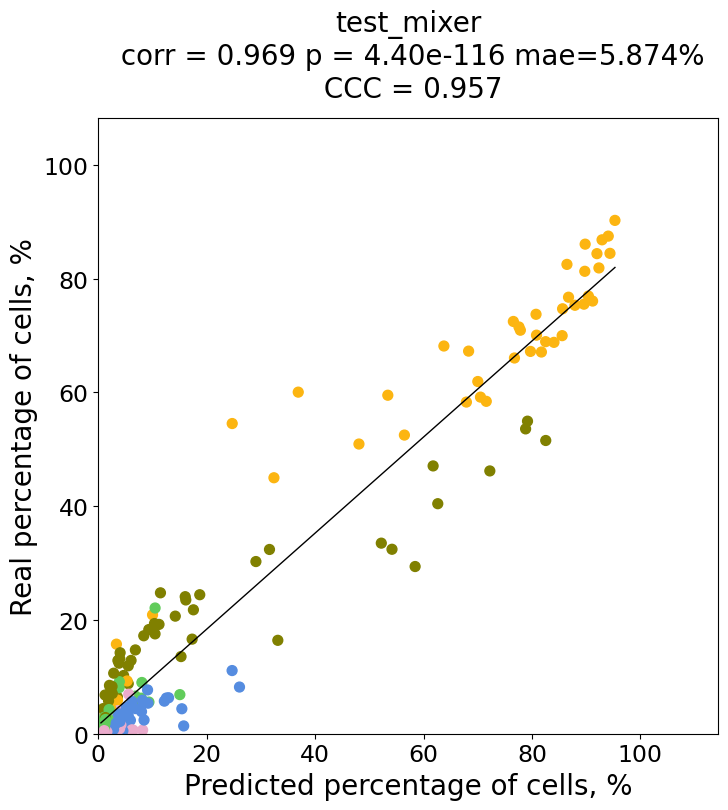

In [118]:
x = print_all_cells_in_one(final_predictions*100, 
                           cytof,
                           pallete=cells_p,
                           title='test_mixer', min_xlim=0, min_ylim=0)
plt.savefig('convnext_all_in_one.jpg', dpi=600, bbox_inches='tight', transparent=False)

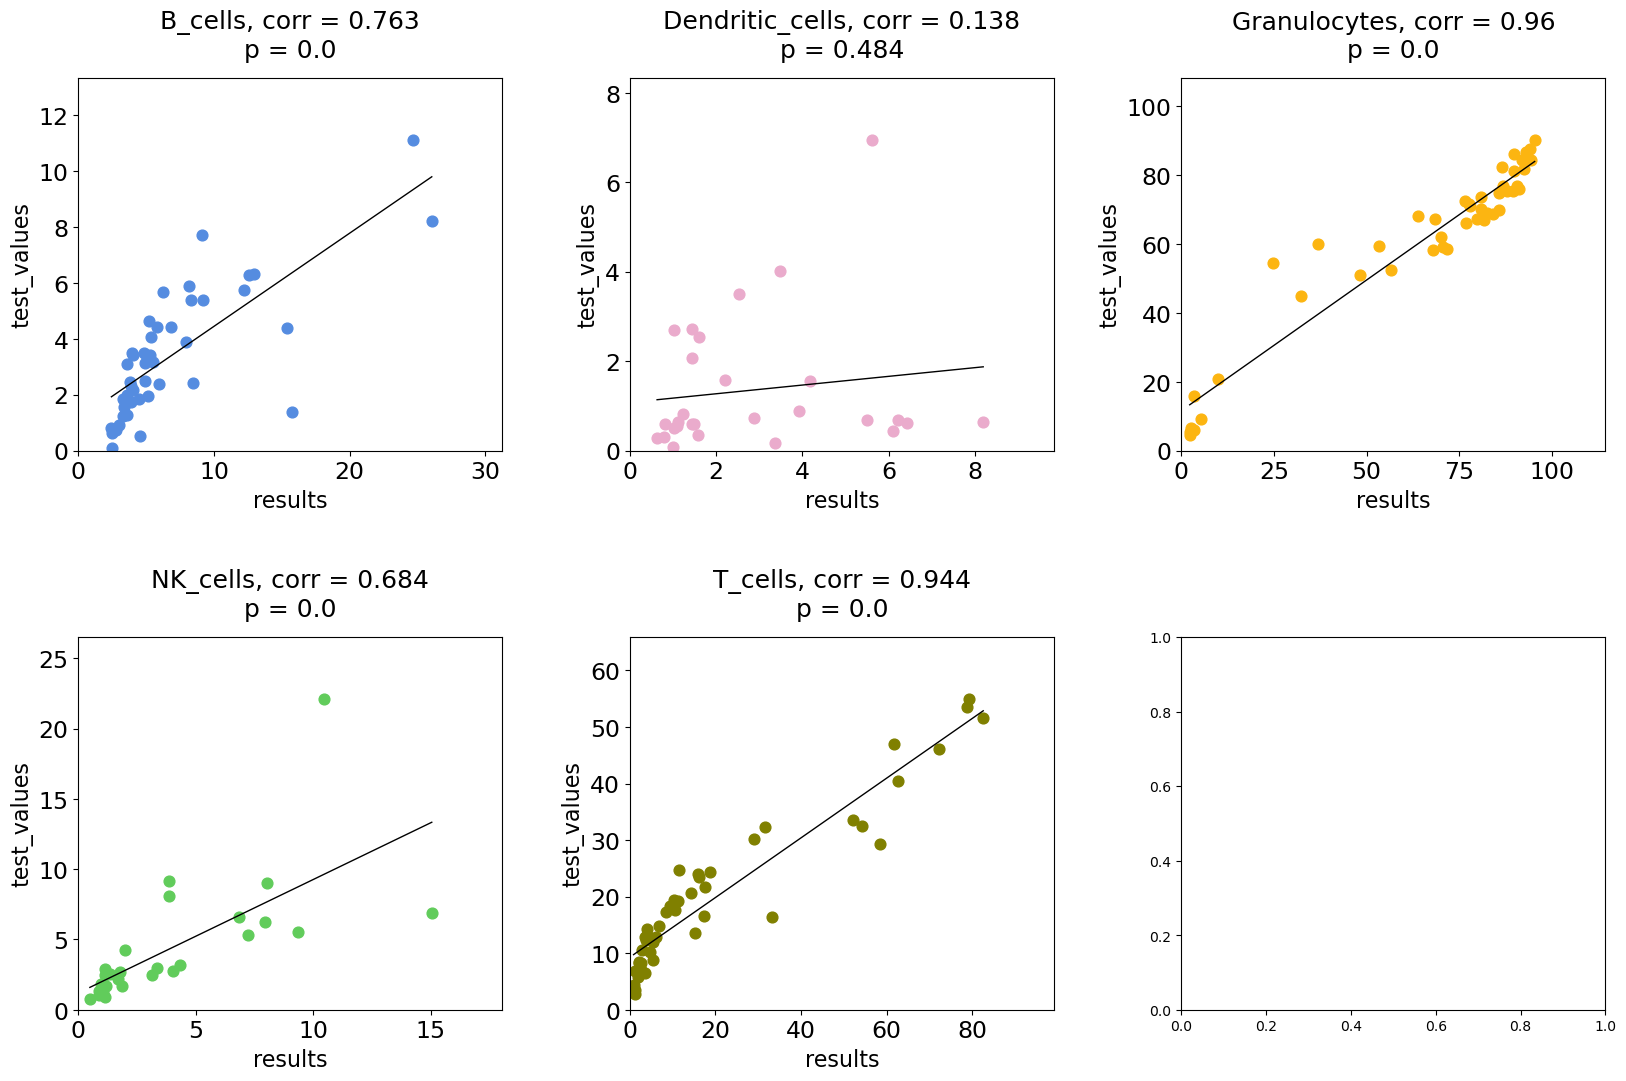

In [58]:
x = print_cell_matras(final_predictions*100, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='test_values', predicted_name='results',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=3, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

plt.savefig('convnext_cells.jpg', dpi=600,  bbox_inches='tight', transparent=False)

## Transformers

In [98]:
adjusted_preds_trans = adjust_rna_fractions(predictions.drop('Tumor'), "./configs/cell_types.yaml", add_other=True)

final_predictions_trans = convert_rna_to_cells_fractions(adjusted_preds_trans, "./configs/cell_types.yaml", other_coeff=1.0)

In [99]:
final_predictions_trans.loc['Lymphocytes'] = final_predictions_trans.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [128]:
final_predictions_trans
# pd.DataFrame(predictions).to_csv('row_predictions_all_trans.csv')

,F0303,F0304,F0305,F0306,F0307,F0308,F0274,F0229,F0230,F0231,...,F0592,F0628,F0629,F0594,F0595,F0596,F0597,F0598,F0462,Other
B_cells,0.005066,0.007944,0.003947,0.011971,0.003582,0.018479,0.003034,0.037605,0.048378,0.066848,...,0.018868,0.000657,0.001181,0.002210,0.008165,0.009865,0.016780,0.010140,0.006472,0.100367
CD4_T_cells,0.003094,0.013066,0.002834,0.006746,0.003501,0.084319,0.002943,0.189873,0.090068,0.058019,...,0.004664,0.002051,0.002597,0.002737,0.082622,0.003142,0.075090,0.021045,0.019962,0.100367
CD8_T_cells,0.193531,0.245183,0.152893,0.256179,0.151997,0.251521,0.080692,0.274372,0.283549,0.295577,...,0.187950,0.023210,0.064079,0.152183,0.076426,0.216240,0.239973,0.260379,0.166109,0.100367
Dendritic_cells,0.043847,0.024732,0.048788,0.034584,0.053052,0.033420,0.015547,0.011886,0.042673,0.003091,...,0.041182,0.034471,0.036762,0.044175,0.023571,0.020001,0.041250,0.057581,0.017900,0.026095
Endothelium,0.001210,0.000526,0.001426,0.001075,0.002081,0.000742,0.000234,0.000315,0.001211,0.000640,...,0.000207,0.000257,0.000844,0.000750,0.001207,0.000279,0.000870,0.000328,0.000433,0.010492
Fibroblasts,0.000814,0.001053,0.000867,0.001231,0.000992,0.001354,0.000643,0.000413,0.000628,0.000573,...,0.000718,0.000711,0.000927,0.000692,0.001717,0.001096,0.000968,0.000660,0.001384,0.010712
Granulocytes,0.599708,0.484505,0.659897,0.456912,0.611108,0.289129,0.741388,0.009480,0.014502,0.007415,...,0.603972,0.891978,0.818332,0.676889,0.612000,0.553825,0.344193,0.391472,0.601053,0.270990
Immune_general,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Macrophages,0.000047,0.000074,0.000043,0.000035,0.000029,0.000055,0.000093,0.000009,0.000008,0.000007,...,0.000124,0.000155,0.000154,0.000094,0.000291,0.000026,0.000022,0.000079,0.000016,0.010037
Monocytes,0.025768,0.011430,0.030463,0.027569,0.061170,0.047450,0.089642,0.130210,0.182063,0.199232,...,0.032497,0.027129,0.001763,0.006809,0.037544,0.046424,0.021246,0.015670,0.022029,0.050183


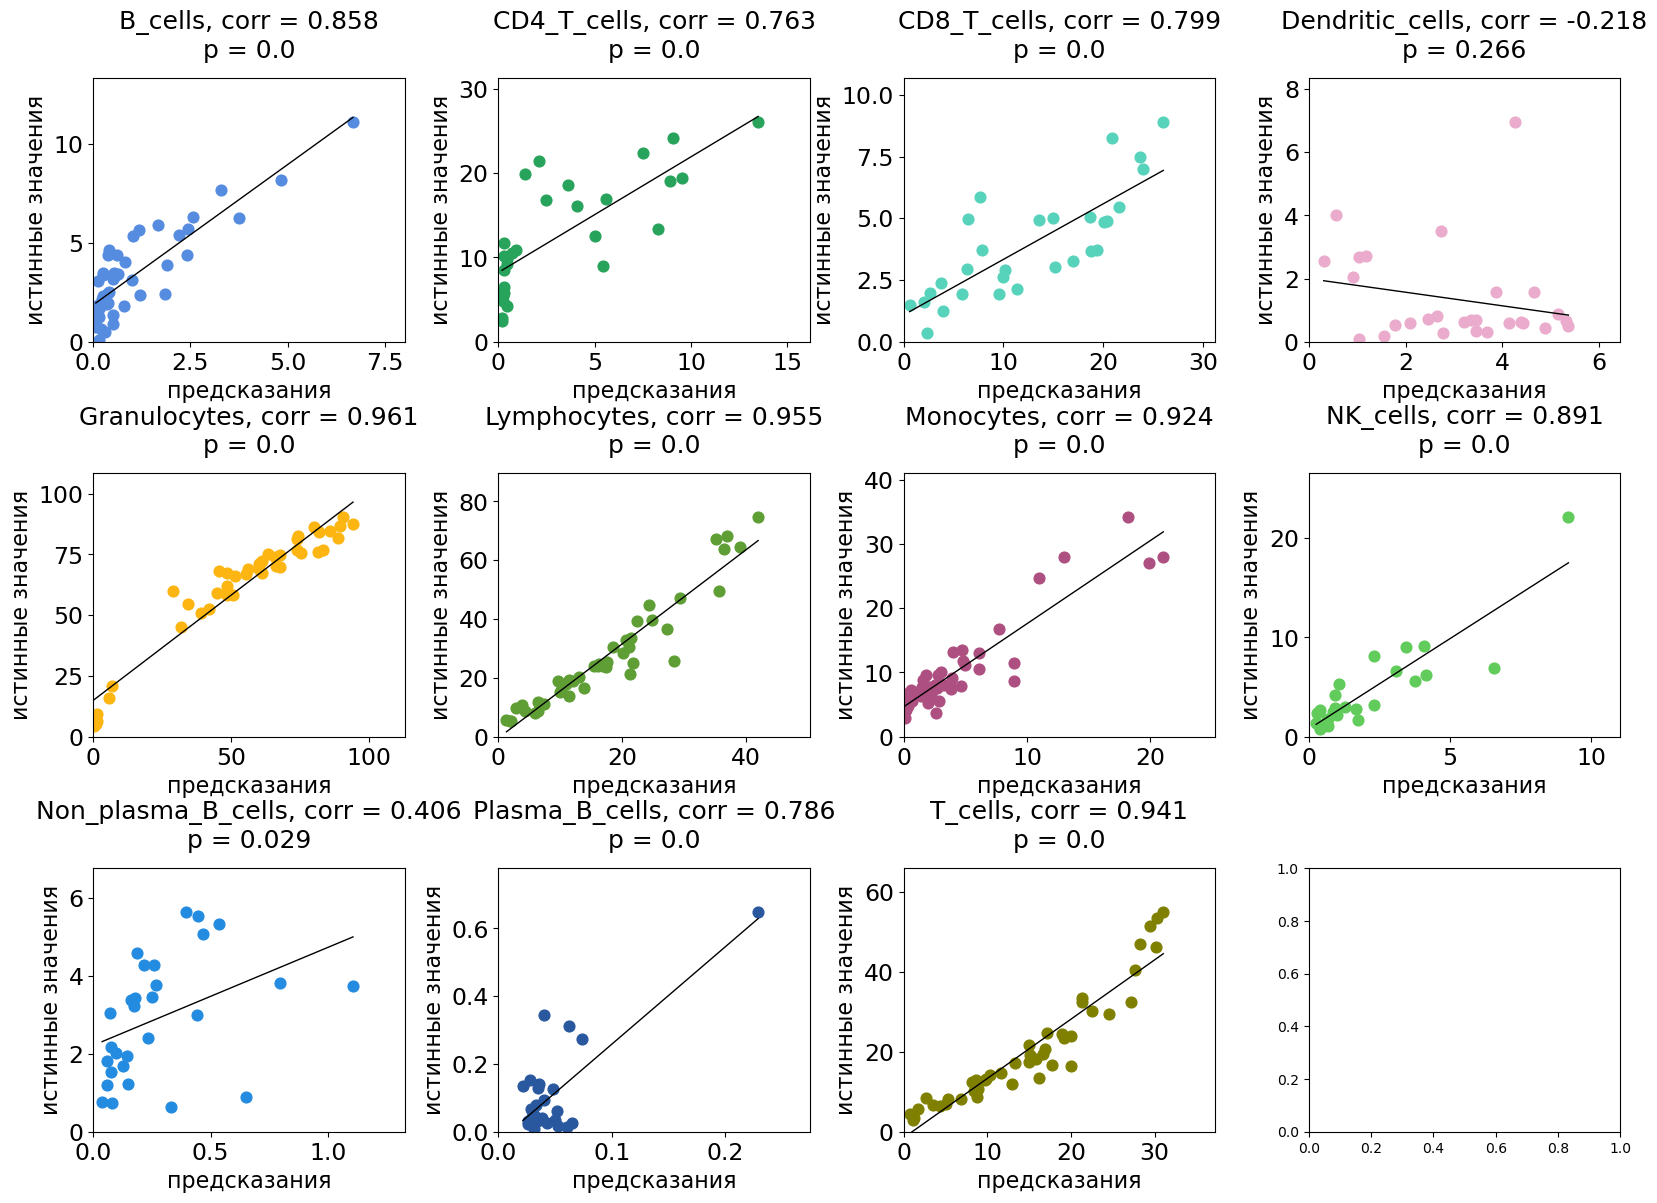

In [101]:
x = print_cell_matras(final_predictions_trans*100, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='истинные значения', predicted_name='предсказания',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=4, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

# plt.savefig("all_transformers.png", dpi=1200, bbox_inches='tight', transparent=False)

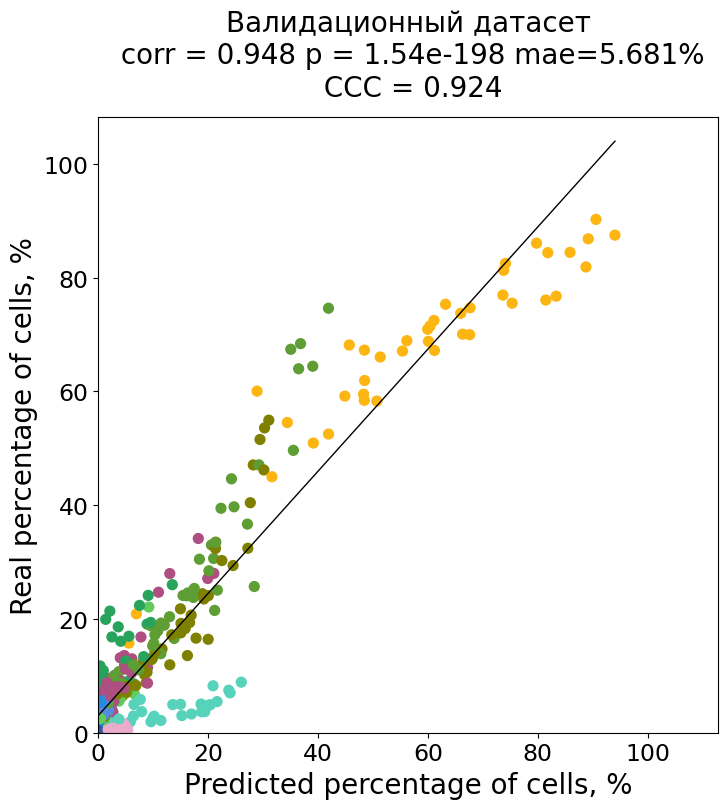

In [91]:
x = print_all_cells_in_one(final_predictions_trans*100, 
                           cytof,
                           pallete=cells_p,
                           title='Валидационный датасет', min_xlim=0, min_ylim=0)

# plt.savefig("all_transformers_results.png", dpi=1200, bbox_inches='tight', transparent=False)

# ConvNeXt VS transformers B_cells

In [121]:
selected_cell = 'B_cells'
onnx_model_path = f'./transformers/{selected_cell}_trans.onnx'

selected_genes = cell_types[selected_cell].genes.copy()
if selected_cell != 'Immune_general':
    selected_genes.extend([item for item in cell_types['Immune_general'].genes if item not in selected_genes])    


val_genes = selected_genes
val_expr = expr.loc[selected_genes]
val_expr = renorm_expressions(val_expr, genes_in_expression_file)
X_test = torch.tensor(val_expr.T.values, dtype=torch.float32)
dummy_data, dummy_target = mixer_test.generate(selected_cell,
                                   selected_genes,
                                   random_seed=17)
indeces = dummy_target.index.copy()
dummy_input = X_test 

try:
    onnx_model = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_model)
    
    ort_session = ort.InferenceSession(onnx_model_path)
except Exception as e:
    print(f"Ошибка при загрузке модели для {selected_cell}: {e}")


all_outputs = []

for i in range(dummy_input.shape[0]):
    single_sample = dummy_input[i:i+1]  # shape: [1, input_dim]

    outputs = ort_session.run(
        None,
        {'bulk_normalized_vector': single_sample.numpy()}
    )[0]

    all_outputs.append(outputs)

outputs = np.vstack(all_outputs) 

predictions_B_cells = np.exp(outputs.T)*100


df_pred = pd.DataFrame(predictions_B_cells, index=indeces, columns=expr.columns)
adjusted_preds_trans_B_cells = adjust_rna_fractions(df_pred.drop('Tumor'), "./configs/cell_types.yaml", add_other=True)
final_predictions_trans_B_cells = convert_rna_to_cells_fractions(adjusted_preds_trans_B_cells, "./configs/cell_types.yaml", other_coeff=1.0)
final_predictions_trans_B_cells*100
# final_predictions_trans_B_cells.to_csv('b_cells_trans.csv')

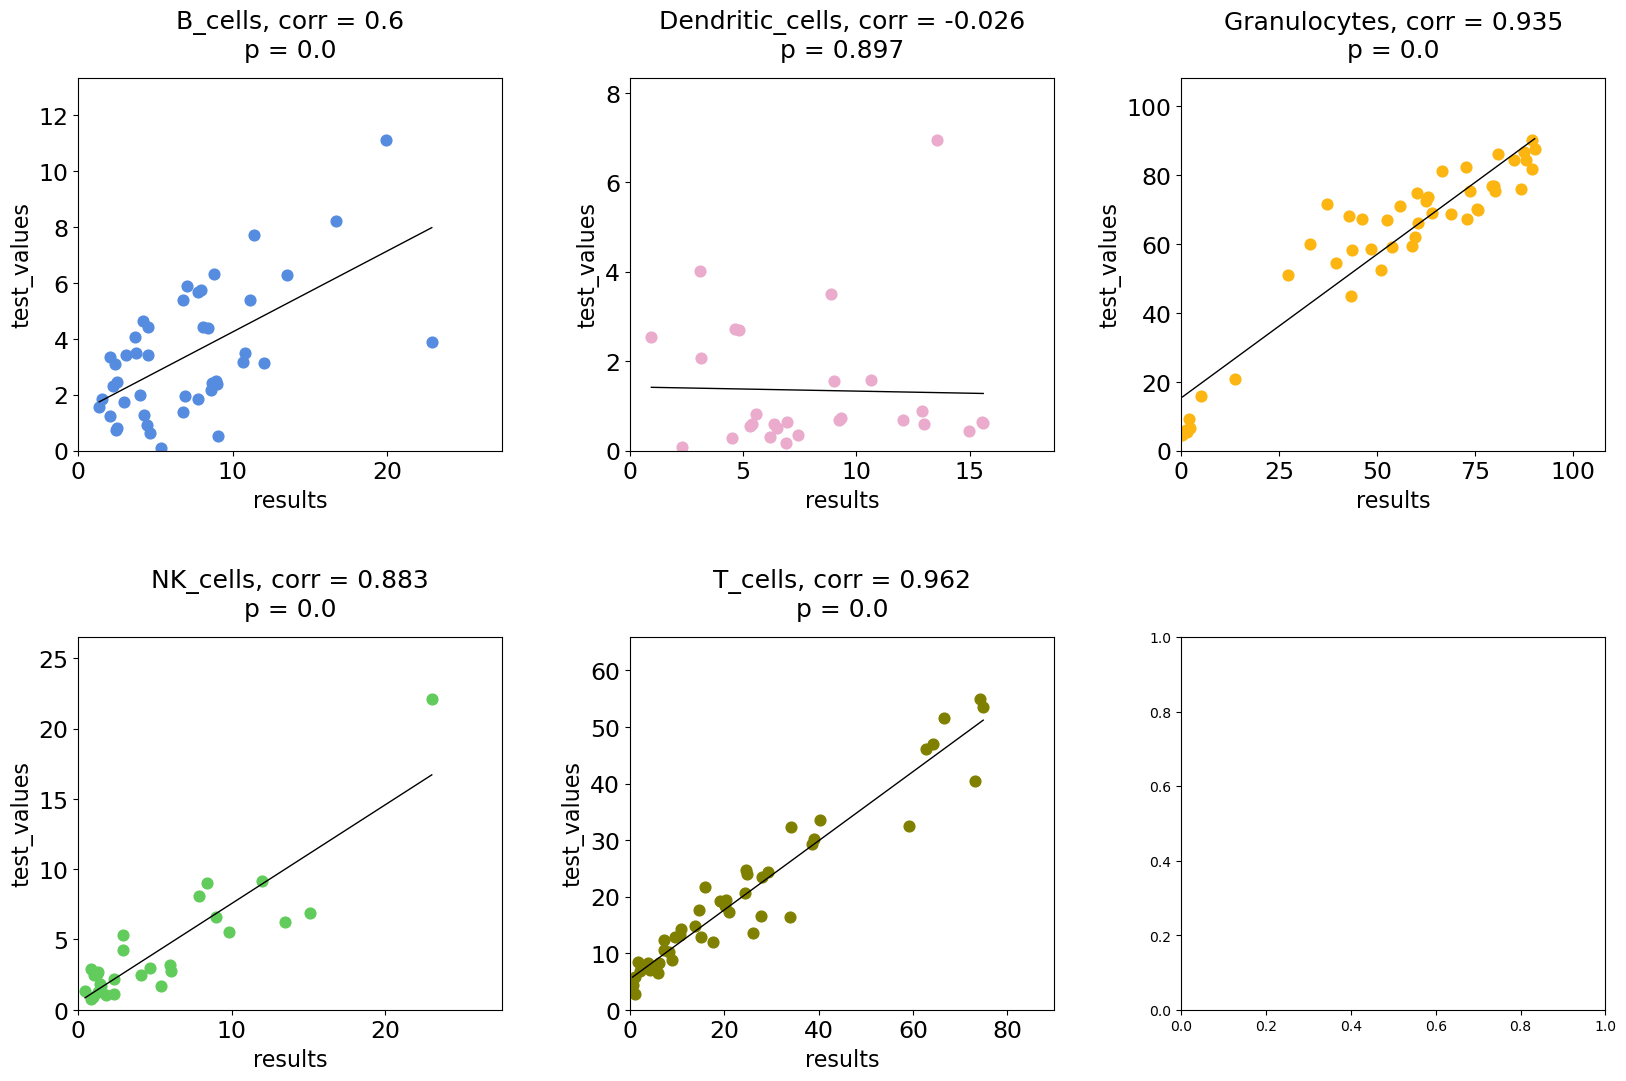

In [106]:
x = print_cell_matras(final_predictions_trans_B_cells*100, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='test_values', predicted_name='results',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=3, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)
# plt.savefig('B_cells_trans.jpg', dpi=600,  bbox_inches='tight', transparent=False)

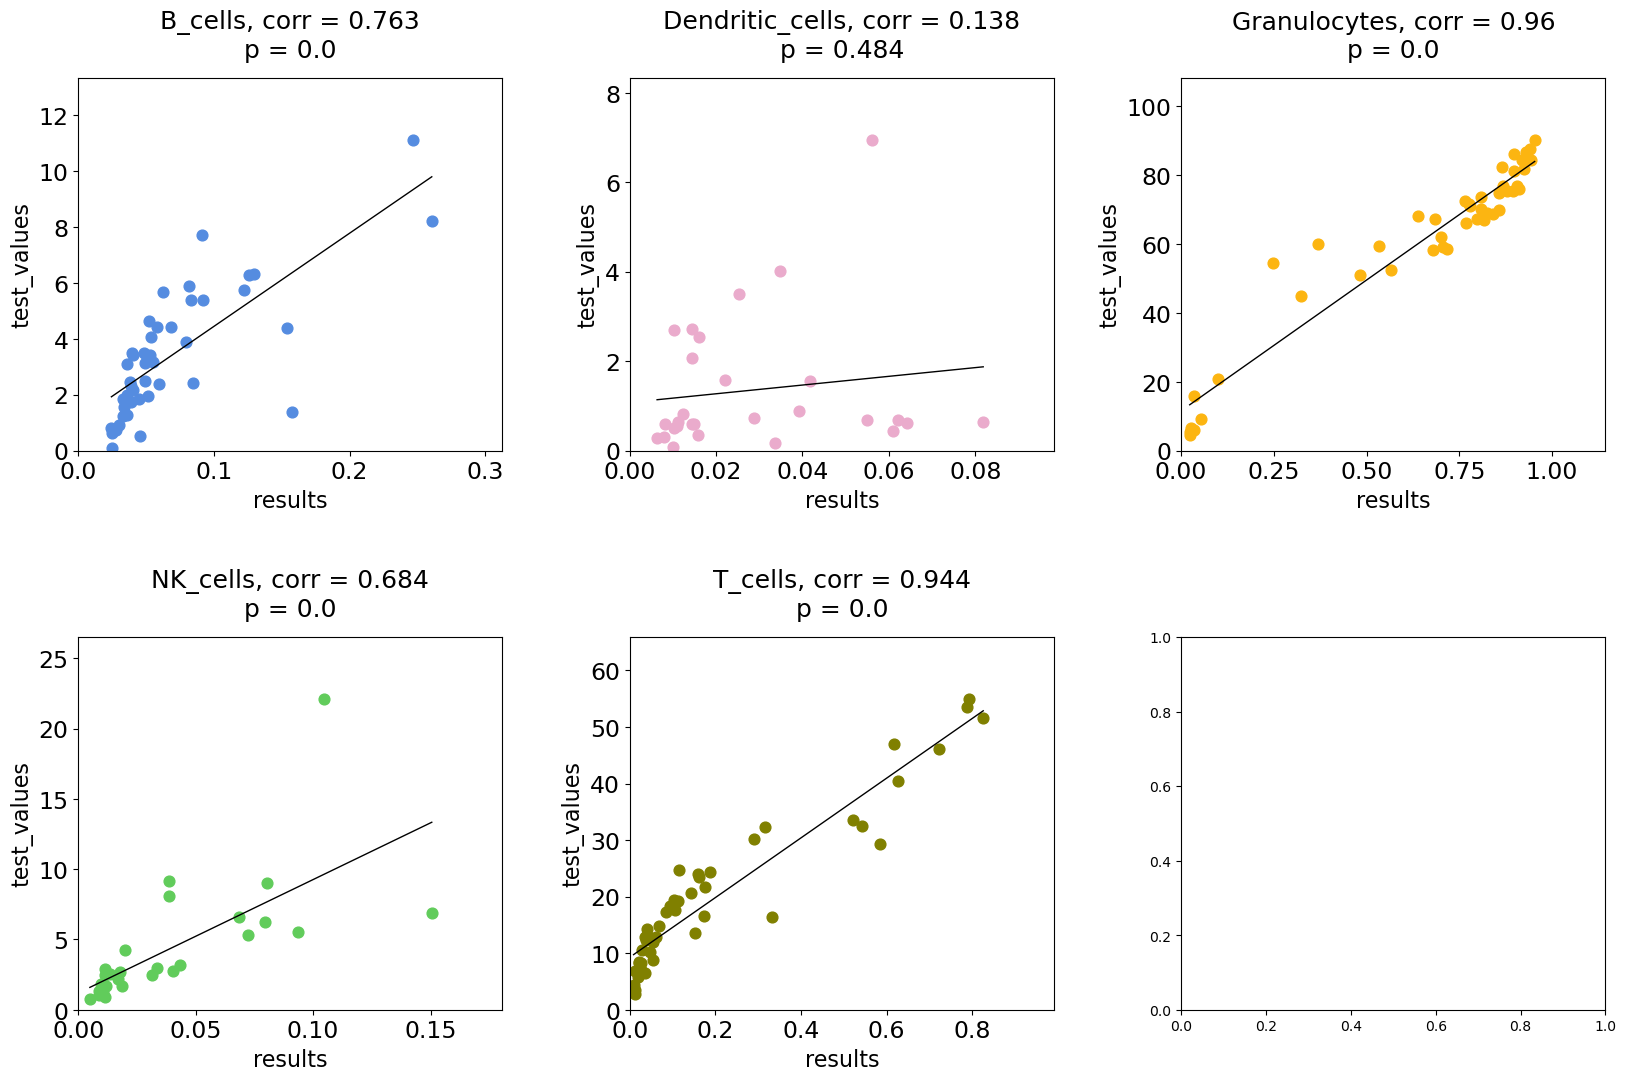

In [120]:
x = print_cell_matras(final_predictions, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='test_values', predicted_name='results',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=3, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

# plt.savefig('B_cells_convnext.jpg', dpi=600,  bbox_inches='tight', transparent=False)